# The Refinery Files 0x08: Flare On 10

This tutorial is a refinery-focused summary of my solutions for [FlareOn][] Vol.10. As in the [previous tutorial][FO9], it will not explore the reverse engineering of the individual challenges quite that much, but at least a little bit more than other refinery tutorials. But remember that this is mostly a refinery showcase, and not so much a detailed walk-through for [FlareOn][].

> _This is a work of fiction. Ideas, shortcuts, and refinery pipelines either are products of the author's imagination or are used fictitiously. Any resemblance to actually implemented CTF solutions, present or past, is entirely coincidental._

The code below is used for making this Jupyter notebook go brrr, you do not have to worry about it.

[FlareOn]: https://flare-on.com/
[FO9]: tbr-files.v0x05.flare.on.9.ipynb

In [1]:
import tutorials.boilerplate

## Challenge 1 - X

In [1]:
%flare v10/01.X.7z X.??? 

14.136 kB f834421563075811d11e6aecc50aef2efe6c52660ce66a1014b09865ff7af60d X.pdb
00.162 MB 5d29a3ad3546757c367ff787cc768818e784b6045d1eabde8c53d08a3f79bfe5 X.dll
00.297 MB 7251db58b565d17260b5e73964e21caf051e699e4096a1064d01c67cd780155d X.exe


The first challenge contains a huge amount of files, but the main executable appears to be `X.exe`, and that one loads `X.dll`. Since I do malware triage for a living, I live for the quick wins:

In [1]:
%emit X.exe X.dll [| xtp email ]

glorified_captcha@flare-on.com


# Challenge 2 - It's On Fire

In [1]:
%flare v10/02.ItsOnFire.7z

13.874 MB eb6e69930b39a97ea4fa8a3c50d54ab7f13ea1223fa9bd2bedca0bbd000b0d92 ItsOnFire.apk


Already an Android sample? Well it's good to get that out of the way early I suppose. I started looking at the source code of [ApkTool][] and considered porting the code to refinery for this tutorial, but 5 factories in I decided to give up.

[ApkTool]: https://apktool.org/

In [1]:
!apktool decode -o dc -f --no-src ItsOnFire.apk

I: Using Apktool 2.10.0 on ItsOnFire.apk with 12 thread(s).
I: Copying raw classes.dex file...
I: Copying raw classes2.dex file...
I: Loading resource table...
I: Decoding file-resources...
I: Decoding values */* XMLs...
I: Decoding AndroidManifest.xml with resources...
I: Regular manifest package...
I: Copying assets and libs...
I: Copying unknown files...
I: Copying original files...
I: Copying META-INF/services directory


The first thing I did was run the app in an emulator; it is a space-invaders inspired game called "Malware Invaders". Nothing in the game gave me any idea how the flag could be recovered, but since it was a game, I thought I should look for anything that looks like encrypted flag data among the resources. I was specifically interested in image resources. So, what do we have? The following pipeline uses the [ef] unit to read all PNG files from the `dc` directory, then [sorted] is used to sort the output chunks by entropy. For the sake of demonstration, I only [pick] the first 5 here, and then we [peek] at their content.

[ef]: https://binref.github.io/#refinery.ef
[sorted]: https://binref.github.io/#refinery.sorted
[pick]: https://binref.github.io/#refinery.pick
[peek]: https://binref.github.io/#refinery.peek

In [1]:
%ef **/*.png [| sorted entropy | pick :5 | peek -l3 ]]

------------------------------------------------------------------------------------------------------------------------
00.474 MB; 100.00% entropy; data
  path = dc/res/raw/iv.png
------------------------------------------------------------------------------------------------------------------------
00000: D9 DA 7B 38 58 2B CE 00 3F 8F C9 47 07 B8 78 89 15 D5 ED 9C 70 D7 DB A9 9E 38 70 B2  ..{8X+..?..G..x.....p....8p.
0001C: A7 EB F3 D4 42 0D F2 8D A4 F2 74 29 2A 49 86 1F 5A 53 5C 5D 2A B1 80 AB BF 88 1F 7D  ....B.....t)*I..ZS\]*......}
00038: 53 1A 41 CD 54 C6 D0 0F C1 10 78 2A 69 2C 30 1A CC B3 5E 95 50 4B C4 AB CA 56 64 4A  S.A.T.....x*i,0...^.PK...VdJ
------------------------------------------------------------------------------------------------------------------------
00.117 MB; 99.98% entropy; data
  path = dc/res/raw/ps.png
------------------------------------------------------------------------------------------------------------------------
00000: 2E 28 C1 F7 91 78 EE 30 24 

Alright, so the two files in `dc/res/raw` which do not even have a valid PNG header look encrypted, so this is definitely something we want to dig into. The next step for me was to open the APK file using [JADX] and use the <kbd>Text Search</kbd> feature available from the <kbd>Navigation</kbd> menu (or press <kbd>Ctrl</kbd>+<kbd>Shift</kbd>+<kbd>F</kbd>). When looking for crypto stuff in Java, I usually search for `SecretKeySpec` or for `doFinal`, both are fairly good keywords to find crypto user code. In this case, there is only one single class that uses these primitives: `p011f.C1186b`. Our next task is to read that code and reverse engineer it. The conclusion is that it decrypts something using AES/CBC, and the cryptographic secrets for this operation are derived from resource-defined strings. The string named `iv` contains the initialization vector, and the key is derived in the following way: 

1. Slices `4:10` and `2:5` are taken from the strings named `c2` and `w1` respectively and concatenated.
2. The CRC32 checksum of the resulting string is computed.
3. The _decimal_ representation of that integer checksum is then concatenated with itself.
4. The first 16 bytes of this string in UTF8 encoding are used as the key.

The following is a refinery pipeline that reproduces this behavior:

[JADX]: https://github.com/skylot/jadx

In [1]:
%%emit dc/res/values/strings.xml [[
        | xtxml w1 iv c2
        | pop w1 iv ]
    | snip 4:10
    | put key
    | eat w1
    | snip 2:5
    | ccp var:key
    | crc32
    | pack -REB4
    | rep 2 []
    | snip :16 
    | put key
    | peek -l0 ]

------------------------------------------------------------------------------------------------------------------------
   iv = abcdefghijklmnop
  key = 4508305374508305
------------------------------------------------------------------------------------------------------------------------


First, we use the [xtxml][] unit to extract the `w1`, `iv`, and `c2` fields from the strings resource. We do this in a doubly nested frame mostly for cosmetic reasons, because when the inner frame closes, some variables generated by [xtxml][] will go out of scope and disappear, so the output at the end will have only the key and initialization vector. We use [pop][] to move the first two extracted strings into equivalently named meta variables. We are now operating on a chunk that contains the `c2` and has two variables containing `w1` and `iv`. We slice `4:10` from `c2` and [put][] the result into a new variable named `key`. We then use [eat][] to replace the current chunk with the contents of `w1`. From that string, we slice out `2:5`. We then use [ccp][] to prepend what we previously stored in `key`. Now we can use [crc32][] to compute the CRC32 checksum of this data, and [pack][] to convert these bytes to their decimal representation. The [rep][] unit is used here with the squeezing operator `[]`, which means that the current chunk is duplicated and the two copies are concatenated directly: Without this, the unit would be emitting two chunks. From this we just have to take the first 16 bytes using [snip][] and we have the key, which we [put][] back into the variable `key`. We carried the variable `iv` all the way, so when we [peek][] the result now, these are the two things we get.

Alright, now we can easily decrypt the images:

[eat]: https://binref.github.io/#refinery.eat
[xtxml]: https://binref.github.io/#refinery.xtxml
[ccp]: https://binref.github.io/#refinery.ccp
[crc32]: https://binref.github.io/#refinery.crc32
[pack]: https://binref.github.io/#refinery.pack
[rep]: https://binref.github.io/#refinery.rep
[snip]: https://binref.github.io/#refinery.snip
[pop]: https://binref.github.io/#refinery.pop
[peek]: https://binref.github.io/#refinery.peek
[put]: https://binref.github.io/#refinery.put

In [1]:
%ef dc/res/raw/*.png [| aes --iv=abcdefghijklmnop 4508305374508305 | peek -ml0 | dump img{index}.png ]

------------------------------------------------------------------------------------------------------------------------
  entropy = 93.95%
    magic = PNG image data, 4083 x 1902, 8-bit/color RGBA, non-interlaced
     path = dc/res/raw/iv.png
     size = 00.474 MB
------------------------------------------------------------------------------------------------------------------------
  entropy = 96.78%
    magic = JPEG image data, Exif standard: [TIFF image data, big-endian, direntries=6, orientation=upper-left, xreso...
     path = dc/res/raw/ps.png
     size = 00.117 MB
------------------------------------------------------------------------------------------------------------------------


It turns out that the first image, i.e. the one encrypted as `iv.png`, contains the flag!

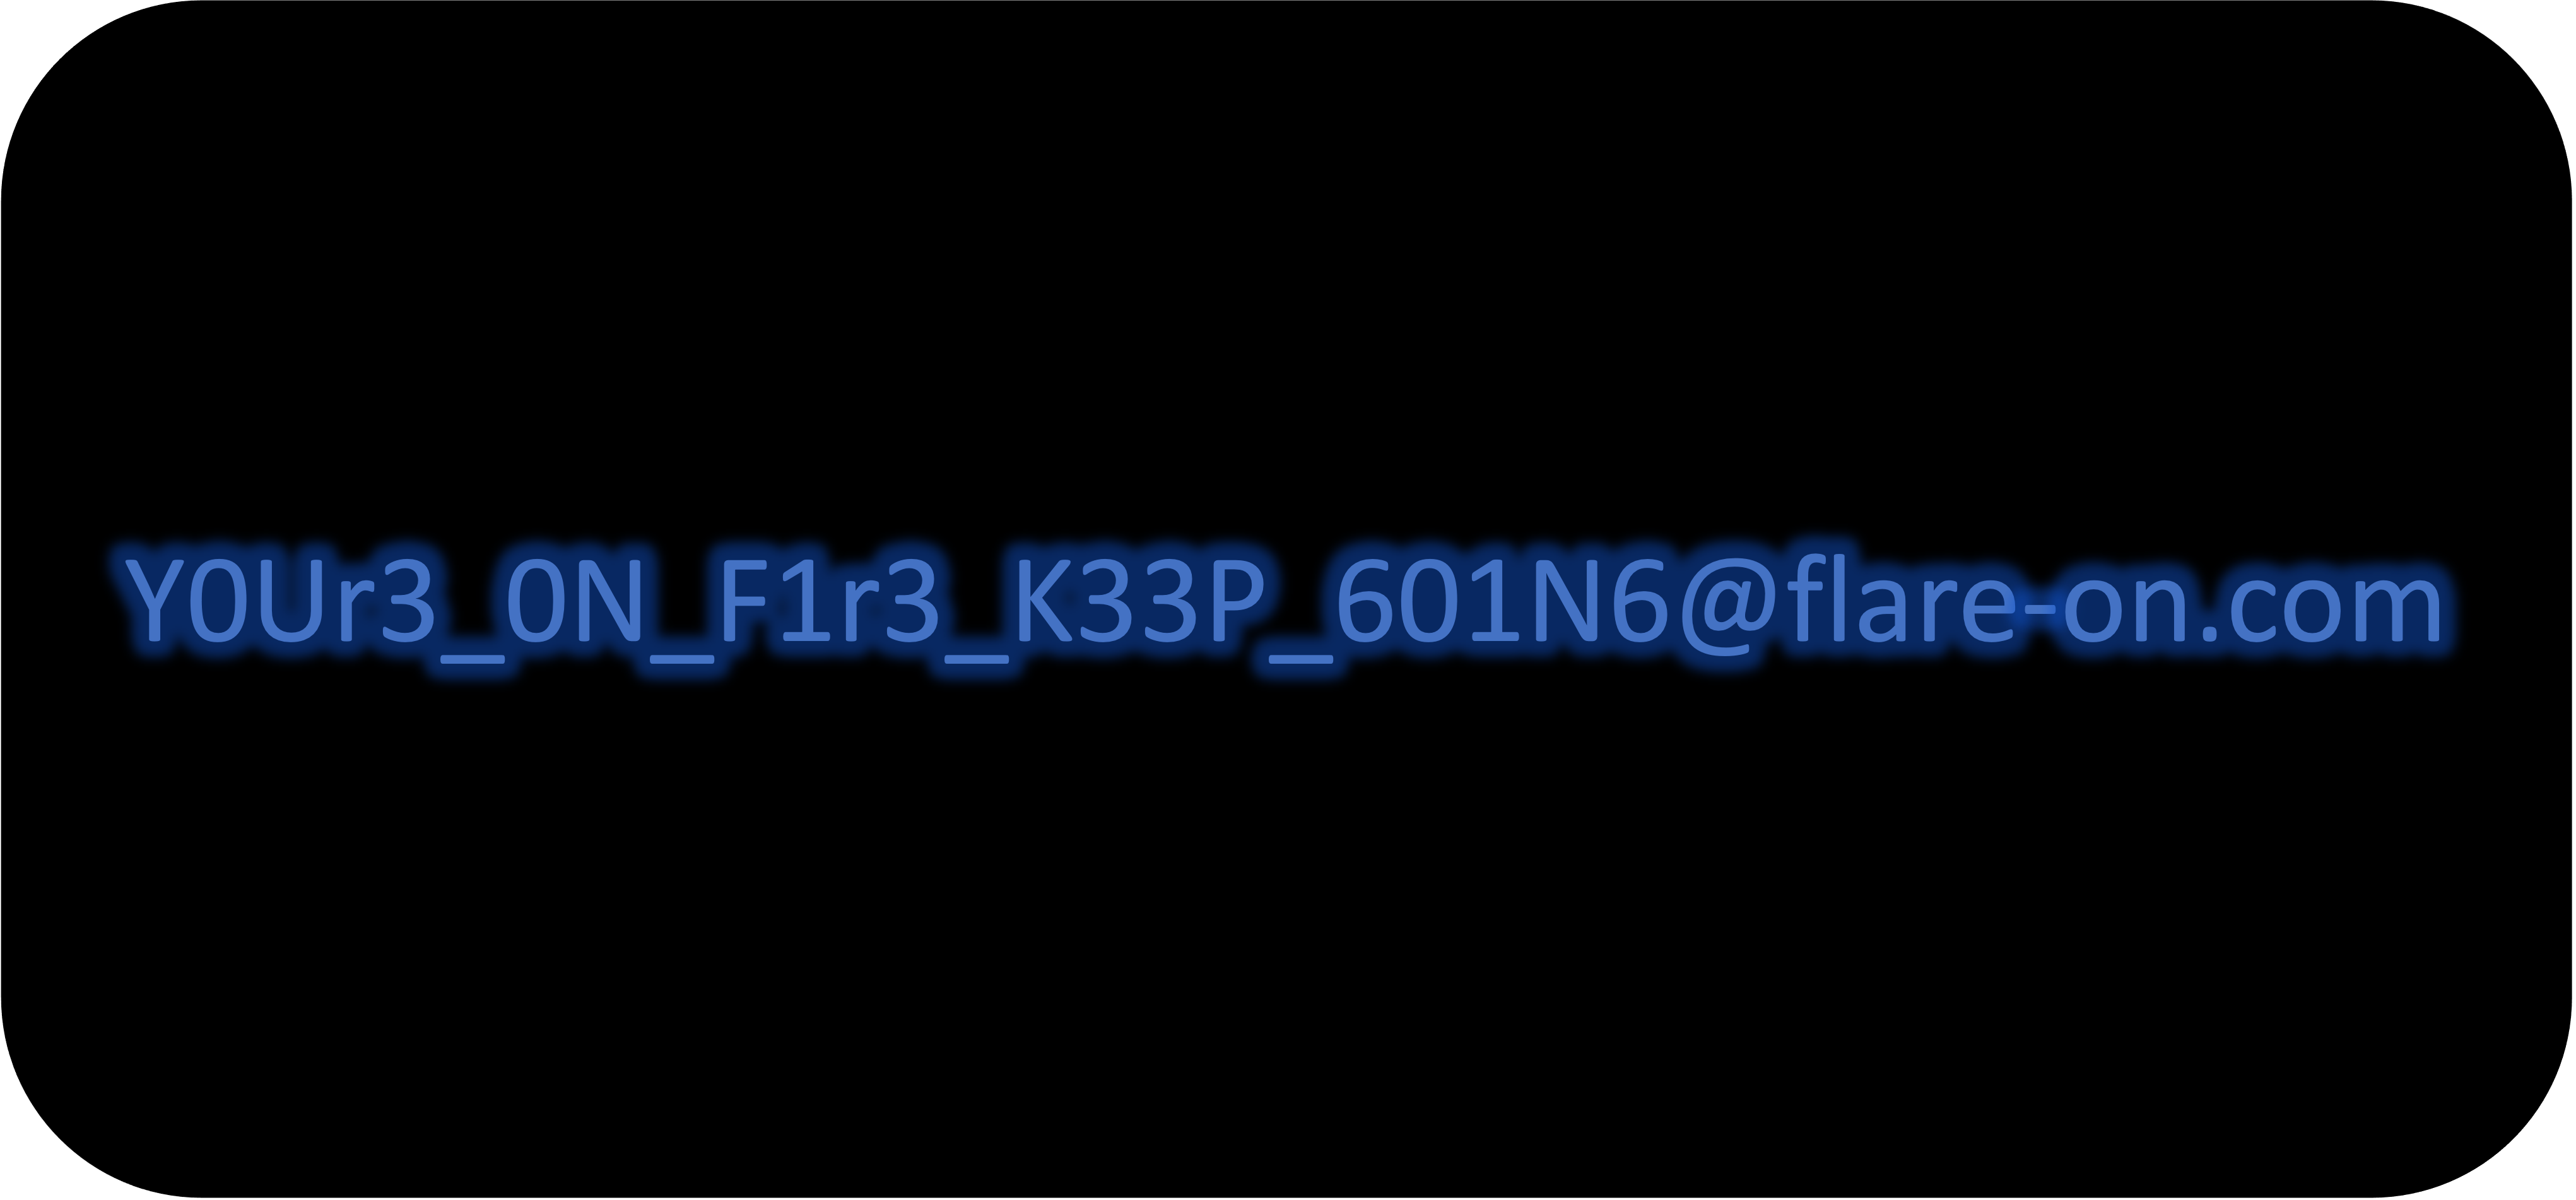

In [1]:
%show img0.png

Not really sure what the other image is about ...

# Challenge 3 - My Passion

In [1]:
%flare v10/03.mypassion.7z

00.299 MB ac6357ea3ab689a774909707559e2ce214e80eb5308dafaaa878d973ca1f2617 mypassion.exe


This is a Windows PE file that expects a single command line argument. It then performs a sequence of convoluted checks on various parts of this input before deriving a key from it that is used to decrypt the flag. Some checks include patching pieces of shellcode with bytes from the input string and running this shellcode to resolve the required APIs for printing to STDOUT.

Refinery played no major part in solving this challenge and try as I might, I cannot make up a story where it did, either. Hence, I won't go into detail here about how I solved this, I am sure there will be plenty of write-ups online that cover this one in depth. Here's the flag for completeness' sake:
```
b0rn_t0_5truc7_b4by@flare-on.com
```
If I find the time, I will retrace my steps and update the tutorial with how to solve this one. Apologies to anyone who was looking for this, I know it was a little arduous to work through and maybe you were hoping I had a silver bullet. Sadly, I don't, I simply gnawed through the code with the tenacity of a seasoned reverse engineer.

# Challenge 4 - AimBot

In [1]:
%flare v10/04.aimbot.7z

09.157 MB 0689f20e973f5834145bf5946f417c3796a891f5a37dddb1430d32895277195b aimbot.exe


The executable is likely a backdoored aimbot for the game "Sauerbraten". Since I was focused on the flag, I don't know exactly how much of either it is, but there's code that looks like an aimbot and it covertly runs a copy of XMRig. A first look at the executable tells us that there are three resources, encrypted with AES-128/ECB using the hard-coded key `yummyvitamincjoy`. It's quite notable that the decrypted buffers always start with a happy little string telling you that decryption was successful. I suspect that this was added to make brute forcing easier.

In [1]:
%emit aimbot.exe | perc [| aes yummyvitamincjoy | peek -beW42 | snip 42: | dump miner.exe config.json aimbot.dll ]

08.251 MB: the decryption of this blob was successful
00.536 kB: the decryption of this blob was successful
00.878 MB: the decryption of this blob was successful


In [1]:
%ls

09.157 MB 0689f20e973f5834145bf5946f417c3796a891f5a37dddb1430d32895277195b aimbot.exe
08.251 MB 9ef2e8714e85dcd116b709894b43babb4a0872225ae7363152013b7fd1bc95bc miner.exe
00.494 kB 69789e7544a174f0250afb9a822670c25cb4ca78b5ab4ae87080ea3cc2825e5a config.json
00.878 MB 5fa34201ba13ed6601a193d0a2a822b4544560d7aaef4d54029eefe3ac577686 aimbot.dll


The `miner.exe` and `config.json` are likely just a legit copy of XMRig with a config, and `aimbot.dll` is the file that we should be looking at. First, we can decrypt the strings (see the string decryption function at `62F439B0`). The following pipeline works as follows:
- Use [put][] to store a backup of the entire DLL buffer in the variable `t`.
- Use [vsnip][] to extract the 4 string pointers from the location `62FE4020`.
- Use [struct][] with the `--multi` option to convert these 32 bytes to 4 chunks, each carrying a variable `a` that contains the pointer value.
- Use [eat][] to replace the chunk body with the back-up copy of the DLL data. We now have 4 chunks in the pipeline, each of which has a variable `a` that points to one string and its body is the entire DLL file.
- Run [vsnip][] again to extract an ASCII string from the location in the PE file that corresponds to the address `a`.
- Use [xor][] to actually decrypt the string with the hard-coded key.
- For prettier output, use [terminate][] to strip everything after the first null byte.

[put]: https://binref.github.io/#refinery.put
[vsnip]: https://binref.github.io/#refinery.vsnip
[struct]: https://binref.github.io/#refinery.struct
[eat]: https://binref.github.io/#refinery.eat
[xor]: https://binref.github.io/#refinery.xor

In [1]:
%emit aimbot.dll [| put t | vsnip 0x62FE4020:32 | struct -m {a:Q} | eat t | vsnip -a eat:a | xor H:A9F89964 | terminate | peek -be ]

00.032 kB: http://127.0.0.1:57328/2/summary
00.014 kB: bananabot 5000
00.012 kB: "version": "
00.042 kB: the decryption of this blob was successful


There are three threads in `aimbot.dll`, and only one of them is interesting: It decrypts a shellcode stage and executes it. The aimbot assumes that the XMRig miner is running and listening on port `57328` on the local machine, as indicated by its config:

In [1]:
%emit config.json | xtjson host port [| pop h | cfmt {h}:{} ]

127.0.0.1:57328


The shellcode is encrypted using 128 bit AES in ECB mode. The key is obtained by searching for the following string in the output from the above XMRig server and taking the 16 bytes following its first occurrence:
```
"version": "
```
Notably, this prefix already consists of 12 bytes, so we only have to brute force 4 characters, and we can be reasonably certain that these characters are only decimal digits and dots. We also know that the decrypted blob should start with the previously noted success message, so we can actually use the brand new [bruteforce][] unit to find the key without even running the miner locally. We use [vsnip][] to emit the first 16 bytes of the encrypted shellcode only (for speed), then [bruteforce][] to generate one chunk for each possible decryption key, then decrypt this block using [aes][], and finally use [iffs][] to filter for blocks that contain the string "decryption", because that would be among the first 16 bytes of the successful decryption header string. Sure enough, we can recover the version this way:

[aes]: https://binref.github.io/#refinery.aes
[bruteforce]: https://binref.github.io/#refinery.bruteforce
[iffs]: https://binref.github.io/#refinery.iffs
[vsnip]: https://binref.github.io/#refinery.vsnip

In [1]:
%%emit aimbot.dll [
    | vsnip 0x62FE7340:0x10
    | bruteforce -r[.0-9] key 4 {2276657273696F6E223A2022!h}{0}
    | aes -r var:key
    | iffs decryption
    | cfmt {key:h!} {key}
]

2276657273696F6E223A2022362E3230 "version": "6.20


What follows is the rather boring task of basically repeating the reverse engineering effort we just did 4 more times. There are 4 shellcode stages, each of which will take bytes from a configuration file of some application and use these bytes to decrypt the next stage. It is a rather boring matter of simply acquiring these software products, installing them, and doing whatever is necessary to generate the config files that the aimbot relies on for decryption, and then copying out the bytes to decrypt the next stage. I will not go into detail about each of these stages, but here is the full refinery pipeline to recover the final shellcode stage, while dumping out the intermediate stages. I always peek the first 42 bytes to make sure that _the decryption of this blob was successful_.

In [1]:
%%emit aimbot.dll [
    | vsnip 0x62FE7340:0x4470
    | aes h:2276657273696F6E223A2022362E3230
    | peek -beW42 | dump -t sc1.bin | snip -l 42+0x929:0x3B19 | rc4 h:22496E7374616C6C436F6E6669675374
    | peek -beW42 | dump -t sc2.bin | snip -l 42+0xF06:0x2BA8 | rc4 h:53514C69746520666F726D6174203300
    | peek -beW42 | dump -t sc3.bin | snip -l 42+0xFB1:0x1BCC | rc4 s:recentWalletFiles
    | peek -beW42 | dump -t sc4.bin | snip -l 42+0xD4B:0x0DA8 | xor h:70563412
    | peek -beW42 | dump    sc5.bin ]

17.517 kB: the decryption of this blob was successful
15.129 kB: the decryption of this blob was successful
11.176 kB: the decryption of this blob was successful
07.116 kB: the decryption of this blob was successful
03.496 kB: the decryption of this blob was successful


At this point the pattern breaks and we actually get to reverse engineer something else. The final shellcode reads from the Sauerbraten shooter's data files to derive the key that decrypts the flag. Because of this, we do need the actual Sauerbraten game because it's the most convenient source for those data files:

In [1]:
!curl -o src.zip -L -s https://github.com/embeddedc/sauerbraten/archive/refs/heads/master.zip

In [1]:
%ls *.zip

00.640 GB 6942078a4baa43e2d6b48823dbfd93755e49471d5e69677e133312b4c555e88c src.zip


The final stage picks the first four bytes and the bytes in range `81:89` from one of the config files. The second set of four bytes are then XOR'd with three different hard-coded values and the resulting bytes are concatenated. At this point, 21 out of the 24 characters of the flag are constructed, so we can assume that the result should contain only characters that we expect to appear in a flag (I have chosen the regular expression `[_$@a-z0-9]` for this), and it should end with an `@`. There would probably be a way to know which of the config files is the right one, but trying them all and then brute forcing the last 3 characters was feasible, and I don't think it's a bad solution, so here's the pipeline:

In [1]:
%%emit src.zip [
    | xtzip *.cfg [
        | snip :4 81:89 [
            | pop x:le
            | cca _
            | cca le:e:x^0x4203120C
            | cca le:e:x^0x1715151E
            | cca le:e:x^0x15040232
            | iffx [_$@a-z0-9]{21}
            | peek -be ]]
    | bruteforce -r[_$@a-z0-9] flag 3 {1}{0}@ 
    | eat flag
    | iff crc32 -eq a5561586
    | cca flare-on.com
    | peek -be ]

00.021 kB: computer_ass1sted_ctf
00.037 kB: computer_ass1sted_ctfing@flare-on.com


# Challenge 5 - Where Am I

In [1]:
%flare v10/05.where_am_i.7z

00.950 MB d576f23d8825e6a46d873df3631e9ff19d847837cfe5a749301608dae104ff83 where_am_i.exe


This was one of the hardest challenges for me because the final step involved a certain element of guesswork. When the sample is executed in a sandbox environment, it will display a message box that simply shows the full path to the executable; not a lot to go on. So let's reverse engineer it! Opening this in Ghidra quickly brings down the mood, because there's a symbol in there that is called `AfxWinMain`, and this is indeed an MFC application. Not wanting to waste time on a top-down analysis in this case, I started looking for entry vectors for a bottom-up approach:
- There are a few odd printable strings that first looked like they could be encoded, but none of them were referenced in the code so I discarded them.
- There are no weird sections or particularly obvious BLOBs anywhere in the data sections.
- But hey, there **are** two very suspicious PE resources! 

Recall that [perc][] can be used to list PE resources and [iff][] is a general purpose filter, in this case we filter for the magic `entropy` variable to be greater or equal to 90%:

[perc]: https://binref.github.io/#refinery.perc
[iff]: https://binref.github.io/#refinery.iff

In [1]:
%emit where_am_i.exe | perc [| iff entropy -ge 0.9 | peek -l2 ]

------------------------------------------------------------------------------------------------------------------------
27.716 kB; 99.91% entropy; data
    lcid = Neutral Locale Language
  offset = 0x7E238
    path = BITMAP/1/0
------------------------------------------------------------------------------------------------------------------------
00000: A3 8F A1 55 A0 20 8B 75 3D 0D F4 0F C0 59 DC 7B 80 F2 C3 9B 30 02 9E C4 A3 78 0B 5E  ...U...u=....Y.{....0....x.^
0001C: 80 3B 7F 63 84 F0 29 2C D5 C2 0A 4F 9F 71 22 CC 10 97 05 C1 70 E9 CF 7D 6C 89 0B 00  .;.c..),...O.q".....p..}l...
------------------------------------------------------------------------------------------------------------------------
86.368 kB; 99.91% entropy; data
    lcid = Neutral Locale Language
  offset = 0x84E7C
    path = BITMAP/2/0
------------------------------------------------------------------------------------------------------------------------
00000: CE 4B A4 C5 1B D7 27 02 ED D6 BD 76 97 B1 29 26 6D 

So there are two `BITMAP` resources that do not look like bitmaps at all and have _very_ high entropy. That's a smoking gun if there ever was one. The next step is to pivot around the API import for `LockResource` and ignoring the references from framework functions, we can quickly filter the list down to one candidate; namely the function at `00448a63`. It reads the first of the two bitmaps and returns the result. It is called only once from what looks like an altered memset function at `00448650`. That function decrypts the code using [rc4][] and executes it as shellcode. The key is hardcoded in the binary right before the text section:

[rc4]: https://binref.github.io/#refinery.rc4

In [1]:
%emit where_am_i.exe | perc BITMAP/1/0 | rc4 pad[256]:H:67C68F1EDAAD1260 | peek -l4 | dump stage1.bin

------------------------------------------------------------------------------------------------------------------------
27.716 kB; 88.91% entropy; data
------------------------------------------------------------------------------------------------------------------------
00000: 55 E9 AA 00 00 00 BE 78 37 28 F0 81 EE 73 33 D4 7A E9 16 6C 00 00 E9 95 00 00 00 59  U......x7(...s3.z..l.......Y
0001C: E9 89 00 00 00 81 F2 B5 50 D5 BE 88 55 B3 5A 51 B9 E1 D3 6B C7 81 F1 82 A5 6A A7 EB  ........P...U.ZQ...k.....j..
00038: 3E 89 5C 24 04 5B FF 15 30 02 46 00 56 BE 56 4A 59 A6 81 C6 88 96 7F 95 81 C6 53 35  >.\$.[..0.F.V.VJY.........S5
00054: D6 CF EB 0B 81 F3 2A 64 BE F3 E9 CA 35 00 00 81 C6 D5 22 93 D8 81 F6 06 39 42 E4 89  ......*d....5.....".....9B..
------------------------------------------------------------------------------------------------------------------------


In [1]:
%emit where_am_i.exe | perc BITMAP/2/0 | rc6 le:e:0xef0001ba -Rr -k 0x10 | peek -l4 | dump stage2.bin

------------------------------------------------------------------------------------------------------------------------
86.368 kB; 98.90% entropy; data
------------------------------------------------------------------------------------------------------------------------
00000: 0A 77 65 6C 63 6F 6D 65 5F 6D 61 69 6E 00 00 00 00 00 00 00 00 01 31 00 00 00 2F 51  .welcome_main.........1.../Q
0001C: 01 00 5C 5C 2E 5C 70 69 70 65 5C 77 68 65 72 65 61 6D 69 00 00 EB 22 EB 19 81 C1 56  ..\\.\pipe\whereami..."....V
00038: D2 72 A6 81 F1 F8 C4 F0 24 E9 C5 00 00 00 EB 06 04 30 02 C1 EB 5F 39 0E E9 F7 01 00  .r......$........0..._9.....
00054: 00 E9 D6 01 00 00 81 C0 2C B5 9F C7 81 F0 DE 8A 3A 7C 51 B9 F8 C7 56 98 81 C1 39 C6  ........,.......:|Q...V...9.
------------------------------------------------------------------------------------------------------------------------


This second shellcode performs an egg hunt to find an encrypted reflective DLL payload inside itself. The marker is the little endian encoding of the number `0xd2a3fb95`. After finding the payload, a custom decryption step is performed which I re-implemented as follows. Note that when creating a custom unit with a constructor that takes an argument like `key`, you do not have to specify a body and can simply put a literal ellipsis there. Refinery will replace the init routine with boilerplate code to populate the `args` property so you can access `self.args.key` in the `process` method.

In [1]:
#!binary-refinery
from refinery import Unit

class dc5(Unit):
    def __init__(self, key):
       ...
    def process(self, data):
        key = self.args.key
        for k, v in enumerate(data):
            j = k % len(key)
            a, b, c, d = [
                x & 0xFF for x in [
                    k * 0x66666667 >> 0x3F,
                    k // 0x0A,
                    k >> 0x1F,
                    k,
            ]]
            t = (((b + c) - a) * (-10) + 0x30 + d) & 0xFF
            data[k] = v ^ key[j] + t & 0xFF
        return data

The key for this custom decryption is stored directly after the egg marker. After the key comes an 8 byte header containing the length and the reflective loader's entry point. We have to decrypt the header and the body separately. In the following pipeline, we first use the `pos` handler to create a variable named `k` that contains the first occurrence of the marker, then we use [snip][] to pick the bytes from that position onward. We use [struct][] to parse out key, header, and payload. We do not give a name to the 8 bytes field containing the header because the [struct][] unit will then emit these bytes as the chunk body, so we can immediately use our custom `dc5` unit to decrypt it. After that, we can use [struct][] again to parse out payload length and the loader offset. We then [eat][] the payload variable, [snip][] it into shape, and decrypt it. The `loader` offset remains a meta variable so we know where to start reversing.

[eat]: https://binref.github.io/#refinery.eat
[struct]: https://binref.github.io/#refinery.struct
[snip]: https://binref.github.io/#refinery.snip
[swap]: https://binref.github.io/#refinery.swap

In [1]:
%%emit stage2.bin [[
        | put k pos:le:0xd2a3fb95
        | snip k: ]
    | struct {key:16}{:8}{payload:}
    | ./dc5.py var:key
    | struct {length:L}{loader:L}
    | eat payload
    | snip :length
    | ./dc5.py var:key
    | peek
    | dump stage3.bin
]

------------------------------------------------------------------------------------------------------------------------
84.674 kB; 78.57% entropy; data
     key = h:95fba3d2ef7642d933444883be221337
  length = 0x371343F1
  loader = 0x14C0000
------------------------------------------------------------------------------------------------------------------------
00000: F1 43 13 37 00 00 4C 01 05 00 03 FC 03 FC 00 00 00 00 00 00 00 00 E0 00 02 21 0B 01  .C.7..L..................!..
0001C: 0E 23 00 C6 00 00 00 88 00 00 00 00 00 00 BD 18 00 00 00 10 00 00 00 E0 00 00 00 00  .#..........................
00038: 00 10 00 10 00 00 00 02 00 00 06 00 00 00 00 00 00 00 06 00 00 00 00 00 00 00 00 90  ............................
00054: 01 00 00 04 00 00 00 00 00 00 02 00 40 01 00 00 10 00 00 10 00 00 00 00 10 00 00 10  ............@...............
00070: 00 00 00 00 00 00 10 00 00 00 D0 38 01 00 5C 00 00 00 2C 39 01 00 50 00 00 00 00 70  ...........8..\...,9..P....p
0008C: 01 00 E0 01 00 00 00 00 0

You can now either manually unmap the reflective DLL or just dump it from memory. Regardless of how you do it: Reverse engineering the DLL reveals that the DLL really doesn't do a whole lot. It does a few checks, reads something from a pipe, and displays message boxes. Nothing in the entire chain does actually directly reference the flag. I suppose you have to take the egg hunting and a few value checks as subtle hints: The flag is actually stored in a buffer that is enclosed by `0xBAADBEEF` values inside the DLL. It also contains an interesting string that will be displayed as a second message box when the executable's path is in the user's home directory:

> _Heard there's RC6 somewhere, is that true?_

I suppose this should serve as another hint; To get the flag you have to decrypt that enclosed buffer using the same [rc6][] key as the second stage.

[rc6]: https://binref.github.io/#refinery.rc6

In [1]:
%%emit stage3.bin [
    | rex Y:EFBEADBA(.*?)EFBEADBA {1}
    | rc6 le:e:0xef0001ba -Rr -k 0x10
    | rex [!-z]+@flare-on.com
]

WheR3_4m_I_fr0m_0TF@flare-on.com


PS: We use the [rex][] unit with the YARA handler `Y:` to carve out the buffer. The `Y:` handler allows you to use YARA-like patterns in your regular expression, which is very useful when working on binary data; without this handler, the regular expression would have looked like this:
```
\xEF\xBE\xAD\xBA(.*?)\xEF\xBE\xAD\xBA
```
And if you need to escape those backslashes for your shell, you run a serious risk of getting an aneurism.

[rc6]: https://binref.github.io/#refinery.rc6
[rex]: https://binref.github.io/#refinery.rex

# Challenge 6 - FlareSay

In [1]:
%flare v10/06.flareSay.7z

39.592 kB 403c8813fbaf328198b72437dcd348c0516d7d4772d936fa0a6365b4a4f0685c FlareSay.exe


An absolutely amazing challenge. This slightly malformed PE has a giant DOS stub that actually implements a full 16 bit DOS game. This application can _absolutely_ be run in DOS mode! Here's only a small taste of what awaits you:

In [1]:
%emit FlareSay.exe | rex -I [a-z0-9]{40}

MMMMMMMMMMMMMMMMMNkolo0WMMMMMMMMMMMMMMMM
MMMMMMMMMMMMMMMMNkooold0WMMMMMMMMMMMMMMM
MMMMMMMMMMMMMMMNkoloooldKWMMMMMMMMMMMMMM
MMMMMMMMMMMMMMNOoloooooldKWMMMMMMMMMMMMM
MMMMMMMMMMMMMWOoloooooooldKMMMMMMMMMMMMM
MMMMMMMMMMMMW0olooooooooolxXMMMMMMMMMMMM
MMMMMMMMMMMW0doooooooooooooxXMMMMMMMMMMM
MMMMMMMMMMW0dlooooooooooooooxXMMMMMMMMMM
MMMMMMMMMWKdloooolx0XOoloooookNMMMMMMMMM
MMMMMMMMWKdlooooldKWMNkoooooookNMMMMMMMM
MMMMMMMMKxloooold0WMMMNkoooooookNMMMMMMM
MMMMMMMXxloooolo0WMMMMMNkoooooloONMMMMMM
MMMMMMXxoooooooOWMMMMMMMXxoooooooOWMMMMM
MMMMMNxoooooooONMMMMMMMMMXxloooolo0WMMMM
MMMMNkooooooldOKKKKKKKKKKNKdloooolo0WMMM
MMMNkoooooooooooooollooldKW0dloooold0WMM
MMNOoooooooooooooooooooxKWMW0olooooldKWM
MWOolllllloooooooooooxKWMMMMWOolllllldKM
MN0OOOOOkdooooooood0XNMMMMMMMWKOOOOOOOXM
MMMMMMMWKdlooooodONMMMMMMMMMMMMMMMMMMMMM
MMMMMMMXxloooodOXWMMMMMMMMMMMMMMMMMMMMMM
MMMMMMNkoooookXWMMMMMMMMMMMMMMMMMMMMMMMM
MMMMMNkooooxKWMMMMMMMMMMMMMMMMMMMMMMMMMM
MMMMWOoloxKWMMMMMMMMMMMMMMMMMMMMMMMMMMMM
MMMW0ood0NMMMMMM

But it's even better! The PE does execute in 32bit mode as well. The code for that is quite straightforward: It decrypts a secret and shows the result. But there's a small problem: The decryption key has been nulled and there's a checksum check on it that also fails. I can't be sure because the decryption routine seems to be custom, but I consider it very unlikely that finding this key is feasible without reverse engineering the DOS game, and that also sounds like a lot more fun than cryptoanalysis of some odd ARX stream cipher.

So off to 16 bit land we go, the land of interrupts and setting the correct video mode. Ah, the nostalgia. I spent a good long while fully reverse engineering the game. Here's the cliff notes:
- The game plays a sequence of notes and you have to press arrow keys to replay that exact sequence if you want to advance each level. 
- The sequence is extended by one note with every level.
- The value of a note is the scan code of the key you have to press to play it.
- After each successful completion of a level, the game cycles a secret PRNG state using 128 bit big integer arithmetic. 
- The next state depends on both the previous state and the current score, which is the sum of all notes played so far.
- If you reach level 128, the executable patches itself so the final state of that PRNG becomes the decryption key for the flag.
- The notes are generated from another PRNG, but you can enter a cheat code during the game's loading screen that will seed the PRNG with the same value every time.

Now there's plenty of ways to solve this, of course. One easy way is to patch the executable to just win every level and then send it random keys; the way it's written, this will eventually make the binary patch itself to contain the correct key. But where would be the fun! Let's reimplement everything in binary refinery instead:

- The cheat code sequence is located at offset `0x9DD`, we first need to take that and compute the seed from it.
- After that, we need to run the first PRNG to generate the full set of 128 notes and map them to the values that the game uses to represent them. These are actually the scan codes of the keys you have to press to play the notes, and they correspond to the letters `H`, `P`, `K`, and `M`.
- We then want to compute the scores at each level by summing up the notes.
- After that, it is time to run the second PRNG to generate the key.

The first RNG can be represented in pseudocode as follows:
```
STATE := STATE * 0x5A7F + 0x3079
YIELD STATE // 16384
```
The second RNG looks like this:
```
STATE := (STATE * 65536) + (S * 64) + SCORE - STATE % (1 << 128)
YIELD STATE
```
If you are dedicated enough, you can actually implement this in refinery:

In [1]:
%%emit FlareSay.exe [
    | push
    | snip 0x9DD:
    | emit itob[2]:btoi[2,1]:c::6
    | alu -B2 S+B//32 -eB
    | pop seed:le:snip[~1:]
    | push rep[0x80]:H:00
    | add accu[seed,1,16]:A*0x5A7F+0x3079#A//16384
    | map range:4 HPKM
    | u16 -R
    | alu -B2 -pS+B S
    | pop scores
    | emit byteswap[2]:be:reduce[(S*65536+S*64+B-S)%(2**128),0]:btoi[2]:eat:scores
    | hex -R ]

2B4F9DF2E68593B812D0C1C64C4B8B30


Alright, cool. But we want to beat this challenge without ever running anything, right? So we have to re-implement that blasted cipher from the 32bit code as well. I have no idea what it is, it looks like it's inspired by Salsa20, and here's the code:

In [1]:
#!binary-refinery
from refinery.lib.crypto import rotr32
from refinery.units.crypto.cipher import StreamCipherUnit

import itertools
import struct


class flafla(StreamCipherUnit):
    def _cycle(self, state: list[int]):
        tmp = list(state)
        for _ in range(10):
            for t, a, b, c, r in [
                (0x3, 0x7, 0xB, 0xF, 0x1B), (0x9, 0x1, 0x5, 0xD, 0x1B),
                (0xD, 0x1, 0x5, 0x9, 0x19), (0x1, 0x5, 0x9, 0xD, 0x15),
                (0x5, 0x1, 0x1, 0xD, 0x10), (0x1, 0x0, 0x2, 0x3, 0x1B), 
                (0x7, 0x3, 0xB, 0xF, 0x19), (0xB, 0x3, 0x7, 0xF, 0x15),
                (0xF, 0x7, 0xB, 0xB, 0x10), (0x2, 0x0, 0x1, 0x3, 0x19),
                (0x3, 0x0, 0x1, 0x2, 0x15), (0x0, 0x2, 0x3, 0x3, 0x10),
                (0xB, 0x8, 0x9, 0xA, 0x1B), (0x8, 0x9, 0xA, 0xB, 0x19),
                (0x9, 0x8, 0xA, 0xB, 0x15), (0xA, 0x8, 0x9, 0x9, 0x10),
                (0x4, 0x0, 0x8, 0xC, 0x1B), (0x8, 0x0, 0x4, 0xC, 0x19),
                (0xC, 0x0, 0x4, 0x8, 0x15), (0xE, 0x2, 0x6, 0xA, 0x1B),
                (0x0, 0x8, 0xC, 0xC, 0x10), (0x2, 0x6, 0xA, 0xE, 0x19),
                (0x6, 0x2, 0xA, 0xE, 0x15), (0xA, 0x2, 0x6, 0x6, 0x10),
                (0x6, 0x4, 0x5, 0x7, 0x1B), (0x7, 0x4, 0x5, 0x6, 0x19),
                (0xC, 0xD, 0xE, 0xF, 0x1B), (0x4, 0x5, 0x6, 0x7, 0x15),
                (0x5, 0x4, 0x4, 0x7, 0x10), (0xD, 0xC, 0xE, 0xF, 0x19),
                (0xE, 0xC, 0xD, 0xF, 0x15), (0xF, 0xD, 0xE, 0xE, 0x10),
            ]:
                tmp[t] ^= rotr32(tmp[a] + tmp[b] + tmp[c] & 0xFFFFFFFF, r)
        for k, v in enumerate(tmp):
            state[k] += v
            state[k] &= 0xFFFFFFFF
        return struct.pack('<16L', *state)

    def keystream(self):
        def inv(k):
            return ~k & 0xFFFFFFFF
        key = struct.unpack('<3L', self.args.key[:12])
        k1 = key[0]
        k2 = rotr32(key[0], 0x1C)
        k3 = rotr32(key[1], 0x18)
        k4 = rotr32(key[2], 0x14)
        for k in itertools.count(0, 0x20):
            k0 = k & 0xFFFFFFFF
            state = [
                0x72616c66, k1, inv(k1), k1 ^ k0,
                k2 ^ k0, 0x6f6e2d65, k2, inv(k2),
                inv(k3), k3 ^ k0, 0x6b636f72, k3,
                k4, inv(k4), k4 ^ k0, 0x21212173]
            out = self._cycle(state)
            yield from out[:0x20]

Alright, time to get that flag:

In [1]:
%emit FlareSay.exe | vsnip 0x408ea0:0x54 | ./flafla.py H:2B4F9DF2E68593B812D0C1C64C4B8B30 | u16

Ha$htag_n0_rc4_aNd_Th3n_s0me@flare-on.com 


And for the sake of ~~madness~~ completeness, here's the pipeline that does it all in one:

In [1]:
%%emit FlareSay.exe [[
        | push
        | snip 0x9DD:
        | emit itob[2]:btoi[2,1]:c::6
        | alu -B2 S+B//32 -eB
        | pop seed:le:snip[~1:]
        | push rep[0x80]:H:00
        | add accu[seed,1,16]:A*0x5A7F+0x3079#A//16384
        | map range:4 HPKM
        | u16 -R
        | alu -B2 -pS+B S
        | pop scores ]
    | put key byteswap[2]:be:reduce[(S*65536+S*64+B-S)%(2**128),0]:btoi[2]:eat:scores
    | vsnip 0x408ea0:0x54
    | ./flafla.py var:key
    | u16 ]

Ha$htag_n0_rc4_aNd_Th3n_s0me@flare-on.com 


# Challenge 7 - Flake

In [1]:
%flare v10/07.flake.7z

00.076 kB 13373a4146e6f0403c46c8892d106524315ef840539ed9979f946c218b132e60 demo_conf.txt
00.475 kB aee86302595094814447a06c3b04e98a17389a794b74741b13621565285cd5da mail.txt
10.390 MB d772ac77cfb560c5d5a3053c3596c05467617f01bda5b9e4dca28e4f2271fa99 flake.exe


Since there is a `mail.txt`, I suppose we should read that.

In [1]:
%emit mail.txt | termfit -t

Subject: need your help...
Oliver Shrub, Gardens Department Head, keeps bragging about his high score for this rip off Snake game called Flake. I'm
pretty sure he found a way to cheat the game because there is no way it's possible to score 10,000 points...I mean the
game ships with a sketchy TXT file so there must be something fishy going on here.
Can you look at the game and let me know how I can beat Oliver's high score?
Best,
Nox Shadows Department Head


The executable turns out to be a game written in Python and compiled with Nuitka:

In [1]:
%emit flake.exe | peek -mml0 | xt exe | peek -mml0 

------------------------------------------------------------------------------------------------------------------------
    crc32 = 8c48cd6e
  entropy = 99.94%
    magic = PE32+ executable (console) x86-64, for MS Windows
   sha256 = d772ac77cfb560c5d5a3053c3596c05467617f01bda5b9e4dca28e4f2271fa99
     size = 10.390 MB
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
    crc32 = 1a51f8f0
  entropy = 79.19%
    magic = PE32+ executable (console) x86-64, for MS Windows
   sha256 = 4a10c01fe5f82850677a82b73b6c43f0ab6205b00792b6b0e437da4de1cc9e3d
     size = 09.535 MB
------------------------------------------------------------------------------------------------------------------------


The nuitka binary contains the following text:
```
XOR-encode d3m0_c0nf.txt with 0x22,0x11,0x91,0xff (I think Nuikta strips Python docstrings during compilation so no worries about this comment making its way into the wrong hands)
```
This allows us to decrypt the config, and even inject our own:

In [1]:
%emit demo_conf.txt | b64 | xor h:221191FF | ppjson

{
    "0": "FLAKE Ultimate Pro v10 (Demo)",
    "1": 5,
    "2": 0,
    "3": 2
}


You quickly figure out that you can give yourself a lot of points in the game, but then you're equally quick to hit a brick wall: The game contains a sanity check to have the snake length be equal to the current score, and while you can influence your score, there doesn't seem to be an obvious way to modify the snake length. I do suppose it is the intended solution to now reverse engineer the nuitka binary, find the check, and patch it. However, it is a lot easier to use [PyInjector][] to spawn a Python shell inside the game's process and get the flag from there, and that's what I did. As a small token, here's how you can get the flag from the binary once you know all the keys:

[PyInjector]: https://github.com/Stanislav-Povolotsky/PyInjector

In [1]:
%%emit flake.exe [
    | xt exe 
    | snip -l 0x916933:50 0x91680E:34
    | pop key:xor[H:1BBA8C1B]
    | rc4 eat:key ]

n0Pe_N0t_T0dAy_Nu1TkA@flare-on.com


# Challenge 8 - Among Rust

In [1]:
%flare v10/08.AmongRust.7z

04.185 MB 3487b69a39e845b58af12b53b723e551b46208b125720b1a9c1c5af29d02ba65 06_27_2023_capture.pcapng
00.803 MB dbdae3c9409523591f936feefa32ddea96ff408d0647aed5b9303255df92acb0 infector.exe.mal_
00.405 kB 5dce08df6b417e2566349179bb9c072ca0b978ede4f590b9373e7b360ac77b66 readme.txt


Alright so this challenge has a side channel, and I'll demonstrate it first. The first thing I did was not even look at the executable, but at the PCAP. You can very quickly make out the malware's C2 communication stream, and in refinery we can use the [pcap][] unit to dump it:

[pcap]: https://binref.github.io/#refinery.pcap

In [1]:
%emit 06_27_2023_capture.pcapng [| pcap | iff 192.168.189.128:8345 -in (src,dst) | peek -bD ]

00.032 kB: 6574212C9B4D9334D893BEC2477CB86A70983B3C33952D68A8CC5C0226070ABF        et!,.M.4....G|.jp.;<3.-h..\.&...   
00.006 kB: 41434B5F4B0D                                                            ACK_K.                             
00.032 kB: 0E02F4A9A8B5BEEABA8348D6D2F87C606849DF9A5EEF49A65C98CF07D4C238A6        ..........H...|`hI..^.I.\.....8.   
00.006 kB: 41434B5F4E0D                                                            ACK_N.                             
00.013 kB: 657865632077686F616D690D0A                                              exec.whoami..                      
00.022 kB: 6465736B746F702D31636D7233716C5C757365720A0D                            desktop-1cmr3ql\user..             
00.036 kB: 65786563206D6B64697220433A5C55736572735C757365725C416D6F6E67527573740D  exec.mkdir.C:\Users\user\AmongRust.
00.001 kB: 0D                                                                      .                                  
00.053 kB: 75706C6F616420433A5C55736572735C75736

This is really straightforward to read. First, the client sends 32 bytes which are acknowledged with an `ACK_K`. Then another 32 bytes which are acknowledged with an `ACK_N`. If this doesn't mean "key" and "nonce", I would be very surprised. There are a few `exec` commands which clearly run commands, and then there's also two `upload` instructions. It looks like the client first sends `upload` followed by a path, then the server responds with `ACK_UPLOAD`. Then the client sends the encrypted file data, and the server acknowledges with `ACK_UPLOAD_FIN` after all bytes are received. At the very end, these files are deleted again. However, what we can easily do, is replay the start of this PCAP against a running instance of the malware and simply grab the file `wallpaper.png` after the upload is done. That's what I did, and it does get you the flag.

However, this is boring and I didn't get to do any Rust reversing. So after I was done with FlareOn, I sat down and looked at the infector executable a bit more. I won't even pretend I fully reversed it, but I got far enough to verify that the crypto is [hc256][], which I then had to implement in refinery. And indeed, we can get a fully static solution like this:

[hc256]: https://binref.github.io/#refinery.hc256

In [1]:
%%emit 06_27_2023_capture.pcapng [
    | pcap [
        | iff dst -eq 192.168.189.128:8345
        | pop k n
        | iff size -ge 500
        | hc256 var:k var:n
        | dump wallpaper.png wallpaper.ps1 ]]

In [1]:
%emit wallpaper.ps1 [| peek -d ]

------------------------------------------------------------------------------------------------------------------------
00.708 kB; 66.19% entropy; ASCII text, with CRLF line terminators
---------------------------------------------------------------------------------------------------------------[utf8]---
Add-Type -TypeDefinition @'
using System.Runtime.InteropServices;
public class Wallpaper {
    public const uint SPI_SETDESKWALLPAPER = 0x0014;
    public const uint SPIF_UPDATEINIFILE = 0x01;
    public const uint SPIF_SENDWININICHANGE = 0x02;
    [DllImport("user32.dll", SetLastError = true, CharSet = CharSet.Auto)]
    private static extern int SystemParametersInfo (uint uAction, uint uParam, string lpvParam, uint fuWinIni);
    public static void SetWallpaper (string path) {
        SystemParametersInfo(SPI_SETDESKWALLPAPER, 0, path, SPIF_UPDATEINIFILE | SPIF_SENDWININICHANGE);
-------------------------------------------------------------------------------------------------------

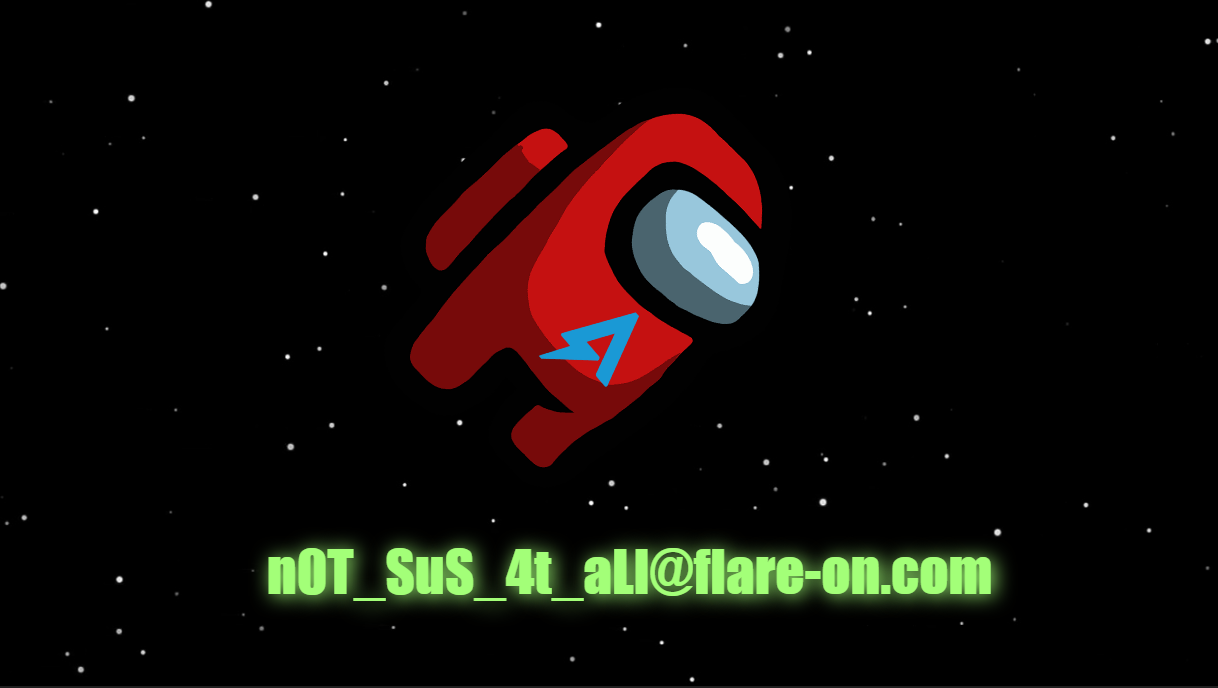

In [1]:
%show wallpaper.png

# Challenge 9 - MBRansom

In [1]:
%flare v10/09.mbransom.7z

00.528 GB 6a061453388e0313af11cab3db0178b6d8808c804a3ebf9933ee554fa4e95f86 hda.img
00.319 kB 95a4fb8af0ea9715796e6e29881e7222673378d03cc12218aa7a1f451c24a506 TIPS.txt
00.529 GB 9abe5d685f25d6d9ac29615ed96e4fb40ddd69ab490ac566c018bb298ae39dce vmware/hda.vmdk
01.095 kB 66ee2e2930c8c05a6626a8ad8ee5adc53f269e963b56d9cd50dbe528bf97c476 vmware/mbransom.vmx
00.271 kB daf6a43422350bd28385f5ec6d476156196019b2d5c3e858b3ac27ed89912b60 vmware/mbransom.vmxf


I find myself wanting to rave about how awesome this challenge is and realize that I only seem to get a kick out of 16bit code. I am getting old. Moving on! The file `hda.img` is an MBR. When you boot from it, it tells you that the disk has been encrypted and that you need to enter 16 hexadecimal characters to unlock it. A quick look at a hex dump shows a very interesting pattern:

In [1]:
emit read[0x8000:0x2000]:hda.img | peek -rW8

---------------------------------------
0000: 31 2A CC 56 66 99 B3 91  1*.Vf...
0008: C6 67 E0 31 19 D0 50 F4  .g.1..P.
0010: 31 30 7D A3 11 16 D6 E9  10}.....
0018: 3B 4C CE B0 47 90 A0 B0  ;L..G...
0020: 12 D9 1F C9 62 DB D2 CD  ....b...
0028: 47 E2 F4 0D 7F CB A9 86  G.......
....:     1017 repetitions
1FF8: 47 E2 F4 0D 7F CB A9 86  G.......
---------------------------------------


So there are a lot of repeating 8-byte blocks in there. This sounds like someone applied a 64bit block cipher in ECB mode to highly structured data: the above repeating sequence is very likely the encryption of 8 null bytes under this cipher. This doesn't immediately break the encryption, but it's something to keep in mind.

Alright, time to look at the boot loader code. The MBR is mapped at `0x7C00` in memory, so the first instruction is basically a `NOP`. Interestingly, while capstone (which is used by refinery's [asm][] unit) can disassemble `ljmp`, [Ghidra][] doesn't disassemble it, which made me unnecessarily suspicious of these 5 bytes.

[asm]: https://binref.github.io/#refinery.asm
[Ghidra]: https://ghidra-sre.org/

In [1]:
%emit read[0x100]:hda.img | asm -c8 x16

0000:  ljmp  0:0x7c05    ; EA 05 7C 00 00  ..|..
0005:  sti               ; FB              .    
0006:  cld               ; FC              .    
0007:  xor   ax, ax      ; 31 C0           1.   
0009:  mov   ds, ax      ; 8E D8           ..   
000B:  mov   es, ax      ; 8E C0           ..   
000D:  mov   bx, 0x7c00  ; BB 00 7C        ..|  
0010:  mov   si, bx      ; 89 DE           ..   


Reversing it a little further, it turns out that the boot loader decrypts part of itself with RC4 using the key `Obfuscation12345`. The following refinery pipeline will dump that second stage:

In [1]:
%emit read[0x2200]:hda.img | snip -l 0x200:0x2000 | rc4 Obfuscation12345 | peek | dump mbransom.bin 

------------------------------------------------------------------------------------------------------------------------
08.192 kB; 98.17% entropy; data
------------------------------------------------------------------------------------------------------------------------
00000: FB FC 8C C8 8E D8 8E C0 FA 8E D0 BC FE FF FB 30 F6 52 56 B8 01 00 CD 10 B8 03 10 B3  ...............0.RV.........
0001C: 01 CD 10 E8 36 00 B4 02 31 DB BA 14 12 CD 10 E8 47 01 E8 8D 01 5E 5A 52 E8 F8 02 73  ....6...1.......G....^ZR...s
00038: 02 EB FE 5A E8 98 04 BE 73 19 E8 C8 02 30 E4 CD 16 3C 0D 74 05 E8 44 01 EB F3 FA EA  ...Z....s....0...<.t..D.....
00054: 00 00 FF FF B9 01 00 31 D2 BE 2A 09 BF 04 00 B4 02 31 DB E8 F9 00 89 F0 89 FB E8 F2  .......1..*......1..........
00070: 00 80 C2 03 80 FA 28 72 EA 84 F6 75 05 BA 00 18 EB E1 B6 02 B4 02 31 DB 30 D2 E8 D6  ......(r...u..........1.0...
0008C: 00 89 F0 89 FB E8 CF 00 B4 02 31 DB B2 27 E8 C6 00 89 F0 89 FB E8 BF 00 80 C6 02 80  ..........1..'..............


After reversing the ransomware for a bit, I identified that the key check happens in the function at offset `0x296`, and of course there's a silly bit that allows you to recover 48 out of the 64 bits: The code downright checks whether the first 6 bytes of the key when XOR'd with the value `0x55` are equal to the 6 bytes at offset `0x9FC`. The remaining two bytes remain unknown, but 16bits are easily [bruteforce][]'d. The code is even kind enough to include a second check in the form of a test vector for the key, the 8 bytes at offset `0x9F4` have to decrypt to the string `Test Str`. This I found a little too easy; the repeated encrypted zero block would have been a good enough test vector and I think I would have preferred if my keen observation would have paid off.

The actual key scheduling receives 16 bytes rather than 8, but bytes 9 through 16 are the first 8 bytes XOR'd with the value `0x55`, so none of these bits provides any security. The key scheduling at offset `0x674` quickly reveals that the encryption algorithm is Blowfish, it very characteristically uses its own block encryption routine during the scheduling. Alternatively, one can look up the magic constants at offset `0xA04` and `0xA78` to figure this out.

Based on these observations, the following refinery pipeline recovers the full decryption key:

[bruteforce]: https://binref.github.io/#refinery.bruteforce

In [1]:
%%emit mbransom.bin [
    | put b c:0x9FC:0xA02
    | put a xor[0x55]:var:b
    | snip -l 0x9F4:8
    | bruteforce key 2 {a}{0}{b}{0:xor[0x55]}
    | blowfish -Qr var:key
    | iffs Test
    | cfmt {key:h!}
]

61D2E6E14A754ADC3487B3B41F201F89


At this point you can either take the first 16 hexadecimal characters and let the ransomware decrypt the disk; or you can simply decrypt the entire disk image and grep out the flag, which quite frankly is a lot easier at this point:

In [1]:
%emit hda.img | blowfish -r h:61d2e6e14a754adc3487b3b41f201f89 | rex [!-z]+@flare-on.com

bl0wf1$h_3ncrypt10n_0f_p@rt1t10n_1n_r3al_m0d3@flare-on.com


# Challenge A - Kupo

In [1]:
%flare v10/10.kupo.7z

06.594 kB 9b8efbbd3d1a2738c8c7a859f488f5736734857fb969286a0e58d2ef9e9dd8c9 forth.tap
00.599 kB 7ee37622b285808ac1d67c01b6be093068eb95f880042d34efce4e1ccda41116 mog.cfg
00.121 GB b07668b36eafdcf5ad825c18288678e34ea9cc8ddd3c5c6273ab5cd84ab0418d mog.dsk
01.867 kB 0f253fb761e172c359784beda75302aacba0b6d9b7f8a607e83a7197dac9fc18 README.md


Here we are. The PDP-11 challenge. Hardest one for me because it was probably the only one that wasn't squat inside my wheel house. I had to actually learn a lot about PDP-11 architecture and Forth. The file `forth.tap` is a SIMH magtape. The config file must be modified with the following line right before the `boot` instruction to make the emulator load the tape:
```
attach ts0 forth.tap
```
After booting, this is how you get the files out of the tape to run the Forth interpreter:
```
# cat /dev/rmt12 > info.txt
# cat /dev/rmt12 > moogle.Z
# uncompress moogle.Z
# chmod +x ./moogle
# ./moogle
MoogleForth starting. Stack: 3802
```
I got some help from a beautiful Unix nerd on how to do this, I am not actually sure where you learn these things. The first file is a text file with more information, and the second is a compressed Forth interpreter called _MoogleForth_. Since [the mag tape format is well-documented][SMM], I also implemented tape file unpacking as the new [xtmagtape][] unit because it's clearly something that needs to be in refinery:

[SMM]: http://simh.trailing-edge.com/docs/simh_magtape.pdf
[xtmagtape]: https://binref.github.io/#refinery.xtmagtape

In [1]:
%emit forth.tap | xtmagtape [| dump info.txt moogle.Z ]

In [1]:
%ls

06.594 kB 9b8efbbd3d1a2738c8c7a859f488f5736734857fb969286a0e58d2ef9e9dd8c9 forth.tap
00.599 kB 7ee37622b285808ac1d67c01b6be093068eb95f880042d34efce4e1ccda41116 mog.cfg
00.121 GB b07668b36eafdcf5ad825c18288678e34ea9cc8ddd3c5c6273ab5cd84ab0418d mog.dsk
01.867 kB 0f253fb761e172c359784beda75302aacba0b6d9b7f8a607e83a7197dac9fc18 README.md
01.885 kB ff3f0488c2332d1d8ad430ae7ff627993ea2310112a11086958dea8afc0b82f3 info.txt
04.591 kB 64487a3de5db0798e6c416923a62e7b5df90d7c72edbff6816d17d364bc8aae2 moogle.Z


In [1]:
%emit moogle.Z | peek -l2

------------------------------------------------------------------------------------------------------------------------
04.591 kB; 96.01% entropy; compress'd data 12 bits
------------------------------------------------------------------------------------------------------------------------
00000: 1F 9D 8C 07 02 30 52 E0 04 00 20 04 38 0E 00 58 08 20 00 80 62 15 B4 39 B8 91 C0 15  .....0R.....8..X....b..9....
0001C: 01 05 00 08 55 60 08 60 00 00 31 79 CA 00 30 A1 E0 5E 02 44 01 18 30 F4 38 07 0E 10  ....U`.`..1y..0..^.D..0.8...
------------------------------------------------------------------------------------------------------------------------


The file `moogle.Z` is compressed using an LZW flavor. I learned later that there is a functioning Python library called [unlzw3][] which handles this format, but at the time I thought that I had to [port][unlzw-port] [the unspeakable C code][unlzw-source] to refinery and that's what I did. Now I have my own implementation and I am keeping it. So here we go:

[unlzw-source]: https://sources.debian.org/data/main/c/cfitsio3/3.080-2/compress.c
[unlzw-port]: https://github.com/binref/refinery/commit/6456d07e9fdac829b5ae3e77a03c01a1d5e2f003
[unlzw3]: https://pypi.org/project/unlzw3/

In [1]:
%emit moogle.Z | lzw | peek -l3 | dump moogle

------------------------------------------------------------------------------------------------------------------------
06.388 kB; 70.16% entropy; PDP-11 executable not stripped
------------------------------------------------------------------------------------------------------------------------
00000: 07 01 8C 0A 4E 00 80 08 38 07 00 00 00 00 01 00 C5 15 DA 0E 37 09 AE 04 0A 00 84 15  ....N...8...........7.......
0001C: 00 00 00 00 03 00 62 79 65 00 26 0A F7 09 88 01 0C 00 00 00 03 00 73 70 40 00 65 11  ......bye.&...........sp@.e.
00038: 07 15 1C 00 00 00 05 00 61 6C 69 67 6E 00 8D 0A CD 45 01 00 07 15 2A 00 00 00 05 00  ........align....E....*.....
------------------------------------------------------------------------------------------------------------------------


The most important piece of information is in the first paragraph of the info text file:

In [1]:
%emit info.txt | resplit "\n\n" [| pick 1 ]| termfit

This may be an interesting challenge for you.  The next file on this tape is an executable Forth environment which
contains a secret and the means for decoding and decrypting that secret.  You'll need Ken Thompson's password, which I
trust you'll be able to find.  Beyond that, you'll need to figure out how the various Forth words want their input,
which will require some detective work on your part.


Alright. Ken Thompson's password is [famously known][pwd] to be `p/q2-q4!`, and feeding that to the right chain of commands in a custom Forth interpreter should yield the flag. Time to parse this ancient executable format and learn a crapton about Forth internals! For this, you have to find and read the man pages about `a.out` and find a Forth nerd who will consequently have the happiest day of his life because you finally called about Forth. The executable format is fairly simple, so I will not go on a long rant about that; you can deduce the structure from the upcoming code snippet. 

The interesting symbols in this binary are the following:

- `decode`
- `decrypt`
- `secret`

Specifically, `secret` is a bunch of unintelligible bytes inside the data segment, it's safe to assume that this is the encoded and encrypted flag.

The Forth words (i.e. the available "commands" of the Forth interpreter) are stored in the text section, in the following format: First there's an integer that links back to the previous Forth word, then two unknown bytes that were always zero (or maybe the link is a long integer?), then the name of the word. Names have a 16bit length prefix and are followed by an optional zero padding byte to align to an even length. After this header, the code begins. Some Forth words are written in pure PDP-11 assembly, like `decrypt` for example. This is straightforward to reverse engineer and you quickly find out that `decrypt` performs a simple XOR. However, it's a little trickier to determine where it gets its arguments from: For that you would have to understand Forth a little better, because `decrypt` calls out to the Forth words `bl` and `parse`. For the Forth solution you have to think about that a little more, but for the refinery solution we don't, because it is safe to assume that we are XOR'ing with `p/q2-q4!`.

Now `decode` is a different story. The first instruction of `decode` is a call out to the Forth word `_docol`, which essentially starts a fetch-interpret loop for the current word. If the first instruction of a Forth word is a call to `_docol`, the remaining body of the word consists of what I will call Forth instructions: A list of 16bit tokens. These are primarily the addresses of other Forth words, but also additional arguments. For example, the Forth word `if` requires an additional value on the stack for the branch location. Having understood the file format, I built a unit to parse out the symbols and extract all relevant information, specifically the `_secret` buffer from the data segment and disassembly of all the Forth words:

[forth]: http://lars.nocrew.org/forth2012/alpha.html
[pwd]: https://www.theregister.com/2019/10/09/ken_thompsons_old_unix_password_cracked/

In [1]:
#!binary-refinery
from refinery.units.formats import PathExtractorUnit, UnpackResult
from refinery.lib.structures import StructReader, Struct

import io
import json


class ForthWord(Struct):
    def __init__(self, reader: StructReader[bytearray]):
        self.pos = reader.tell()
        self.lnk = reader.u32()
        self.sym = reader.read(reader.u16()).decode('latin1')
        reader.byte_align(2)
        self.ptr = reader.tell()
        self.code = None


class dasmf(PathExtractorUnit):
    def unpack(self, data):
        sr = StructReader(data)
        syms = {}
        exec = {
            'magic': sr.u16(),
            'text' : sr.u16(),
            'data' : sr.u16(),
            'bss'  : sr.u16(),
            'syms' : sr.u16(),
            'entry': sr.u16(),
            'spsz' : sr.u16(),
            'pcsz' : sr.u16(),
        }

        text_segment = sr.read(exec['text'])
        data_segment = sr.read(exec['data'])
        syms_segment = sr.read(exec['syms'])

        string_table = sr.read()       
        sr = StructReader(syms_segment)
        data = {}

        while not sr.eof:
            _, name_offset, sym_type, _, sym_value = (
                sr.u16(), sr.u16(), sr.u8(), sr.u8(), sr.u16())
            name_end = string_table.find(b'\0', name_offset)
            sym_name = string_table[name_offset:name_end].decode('latin1')
            self.log_debug(sym_type, sym_name)
            if sym_type == 3:
                sym_value -= exec['text']
                if sym_value >= 0:
                    data[sym_value] = sym_name
                continue
            if sym_type != 2:
                continue
            syms[sym_name] = sym_value

        data_offsets = sorted(data)
        for k, p in enumerate(data_offsets):
            try:
                end = data_offsets[k + 1]
            except IndexError:
                end = None
            yield UnpackResult(F'data/{data[p]}', data_segment[p:end])

        words: list[ForthWord] = []

        reader = StructReader(text_segment)
        reader.seekset(syms['_last'])

        while True:
            word = ForthWord(reader)
            words.append(word)
            if word.lnk == 0:
                break
            reader.seekset(word.lnk)

        words.reverse()
        for k in range(len(words) - 1):
            words[k].code = text_segment[words[k].ptr:words[k + 1].pos]

        words_by_ptr = {word.ptr: word for word in words}

        for word in words:
            codes = StructReader(word.code)
            try:
                opc, rel = codes.read_struct('<Hh')
            except Exception:
                continue
            if opc != 0x937 or rel + word.ptr + 4 != syms['_docol']:
                continue
            dasm = io.StringIO()
            dasm.write(F'word {word.sym}')
            while not codes.eof:
                addr = codes.tell() + word.ptr
                line = F'{addr:04X}: '
                code = codes.u16()
                try:
                    insn = words_by_ptr[code]
                except KeyError:
                    line = F'{line} {code:04X}'
                else:
                    line = F'{line} {insn.sym}'
                    if insn.sym == '."':
                        literal = codes.read(codes.u16()).decode('latin1').replace('\n','\\n')
                        codes.byte_align(2)
                        line = F'{line} {literal}"'
                finally:
                    dasm.write(F'\n{line}')
            path = word.sym.replace('.', 'DOT')
            yield UnpackResult(F'forth/{path}', dasm.getvalue().encode(self.codec))
        
        yield UnpackResult(R'.head.json', json.dumps(exec, indent=4).encode(self.codec))
        yield UnpackResult(F'.text', text_segment)
        yield UnpackResult(F'.data', data_segment)

Alright, that was a lot more code than I thought it would be. But we have a working Forth disassembler! And here is the Forth disassembly of the `decode` word, let's hope it paid off!

In [1]:
%emit moogle | ./dasmf.py decode

word decode
009A:  zero
009C:  >r
009E:  dup
00A0:  if
00A2:  00C0
00A4:  swap
00A6:  dup
00A8:  c@
00AA:  r>
00AC:  +
00AE:  2dup
00B0:  swap
00B2:  c!
00B4:  >r
00B6:  1+
00B8:  swap
00BA:  1-
00BC:  goto
00BE:  009E
00C0:  rdrop
00C2:  2drop
00C4:  ;


After staring at this for a bit and adding comments about the stack layout. Note that I treat the return stack as a single variable `R` because it is conceptually easier to work with:
```
zero        (                 | P N 0     )
>r          ( set R := 0      | P N       )
begin       ( loop            | P N       )
  dup       (                 | P N N     )
while       ( N != 0          | P N       )
  swap      (                 | N P       )
  dup       (                 | N P P     )
  c@        ( push *P         | N P C     )
  r>        ( push  R         | N P C R   )
  +         ( set   C := C+R  | N P C     )
  2dup      (                 | N P C P C )
  swap      (                 | N P C C P )
  c!        ( set  *P := C    | N P C     )
  >r        ( set   R := C    | N P       )
  1+        ( set   P := P+1  | N P       )
  swap      (                 | P N       )
  1-        ( set   N := N-1  | P N       )
repeat rdrop 2drop ;
```
In summary, the decode function has the following pseudocode:
```
def decode(P: bytearray):
    R = 0
    for k, C in enumerate(P):
      R += C
      P[k] = R
```
The word expects two entries on the stack; the address of the input data `P` and its length `N`. At this point you have to realize that the `_secret` bytes are an encrypted _string_ so they also sport a length prefix, otherwise you will be off by 2 for what feels like an agonizing eternity. But once you spot that, you can just decrypt it. Here's the Forth solution using the `count` word to handle the length prefix:
```
secret count decrypt p/q2-q4! 2dup decode type
```
An here's the refinery solution:

In [1]:
%emit moogle | ./dasmf.py _secret | struct H{:{0}} | xor p/q2-q4! | alu S -pS+B

ken_and_dennis_and_brian_and_doug@flare-on.com


We first extract the `_secret` data using our custom parser and then read it as a length-prefixed string using [struct][]. After that we [xor][] with Ken Thompson's password and use the [alu][] unit to decode the result.

[struct]: https://binref.github.io/#refinery.struct
[xor]: https://binref.github.io/#refinery.xor
[alu]: https://binref.github.io/#refinery.alu

# Challenge B - Over The Rainbow

In [1]:
%flare v10/11.over_the_rainbow.7z

00.317 kB 7d3e8c4d2b234692130942a100da50fcfad69c14361adc41a7e6f5f152c2c56b very_important_file.d3crypt_m3
02.244 MB 3d808c4d28c679e4b1097852810ecc701c275b5c40c9c4c856286390656c5f7f FLAREON_2023.exe


People told me this would be a cryptographic challenge, so I was psyched. Turns out it is also very ugly C++, but you don't have to read enough code to warrant spending many hours of your life trying to generate [Ghidra][] FIDs for OpenSSL. Just pop it open and muddle your way through until you get to the bit that is encrypting files. The first thing you find is an encrypted string that contains an RSA public key:

[Ghidra]: https://ghidra-sre.org/

In [1]:
%emit FLAREON_2023.exe | vsnip 0x14020f9b0:0x1c3 | alu B@(K*0x2D+0x7B) | terminate | rsakey text

-- Modulus ---------------------------------------------------------------------
0xC9C330728F68087AFC60A133E49B9D3DE49F0FF9995C5E12E5C65C11897BC718E3E4D272D5A58C
E463755B2C63467F0D09F93C31CB67FE318809AF7FC8B2C8C721AB547CE4DB63DBDFFF5D9B06C857
99FDEE690F90C479C6D0B9E3A3F66E55D63029CE5A02EF84C6AADC5E2241683024CC65D75642AFE0
BABE76F29A677CEB159BE48BB3265EBD2BD519A2AF7E036CC2E6401C37555761A81C3D1D28A456C3
8B91B559035BFF013DDA0439053B9E96F4B278F719E939E677D058BC6E98005AFF230814A497AB34
B7FA902B666D180DE84E24E90F753D79DB0B7217ACB5C46F4D1AA56BEE573F2D47A4337DDD1E2B96
7EDC7038FEEB090DEC7492D94D9689BB61
-- Exponent --------------------------------------------------------------------
3
-- BitSize ---------------------------------------------------------------------
2048


You have to reverse a little more to figure out the structure of the encrypted files. They are encrypted using both a random 24-byte XOR key and with ChaCha20, whose state matrix is also randomized, with the notable exception of the last 16 bytes which contain the ChaCha constant. The XOR key and the ChaCha matrix are then encrypted using textbook RSA with the above key.

This was fairly easy for me because I spent 10 years of my life pursuing a mathematical research career. I learned later that this attack also has a name, but if you know just a tiny bit of modular arithmetic, you can just figure it out with a few simple calculations. The weakness is, of course, the low exponent of 3.

The RSA cryptosystem here computes $c=p^3$, where $p$ is the plaintext message, $c$ is the ciphertext, and all operations happen inside the ring $\mathbb{Z}/N\mathbb{Z}$ where $N$ is the RSA modulus. We can furthermore write $m= k + bX$ where $k$ is the ChaCha constant, $b=2^{128}$, and $X$ represents the upper 576 bits of the secret. Multiplying out, we get:
$$
k^3 + 3k^2bX + 3kb^2X^2 + b^3X^3 = c
$$
We can compute the modular inverse of $b$ because it doesn't share a divisor with $N$, so this equation simplifies to:
$$
3k^2X  + 3kbX^2 + b^2X^3 = (c - k^3)b^{-1}.
$$
The key point is that both sides of this equation now have less than 2048 bits, so we can solve for $X$ over $\mathbb{Z}$, and if $x$ is a valid solution then we can get back the plaintext message by computing $m = k+bx$. Here's a refinery unit that does it using [sympy][], which is an excellent Python library for symbolic calculation.

[sympy]: https://www.sympy.org/en/index.html

In [1]:
#!binary-refinery
from sympy.abc import X
from sympy import roots

from refinery import Unit
from refinery.units.crypto.cipher.rsa import normalize_rsa_key

class crack(Unit):

    def __init__(self, key):
        pass

    def process(self, data):
        k = 0x0657870616E642033322D62797465206B
        b = 0x100000000000000000000000000000000
        n = normalize_rsa_key(self.args.key).n
        keys = data[-0x100:]
        c = int.from_bytes(keys, 'big')
        binv = pow(b, -1, n)
        frac = (c-k**3) * binv % n
        solutions = [s for s in roots( 3*k*(X**2)*b + 3*(k**2)*X + (b**2)*(X**3) - frac ) if s.is_integer]
        x = int(solutions[0])
        keys = ((b * x) + k).to_bytes(88, 'big')
        yield keys[:0x18]
        yield keys[0x18:]
        yield data[:-0x100]

Now all we have to do is stick these together: Extract the RSA key as before, use our `crack` unit to generate the XOR key `xk`, the ChaCha key `ck`, and the encrypted data, [pop][] the keys, and then decrypt the flag.

[pop]: https://binref.github.io/#refinery.pop

In [1]:
%%emit very_important_file.d3crypt_m3 [
    | push FLAREON_2023.exe
    | vsnip 0x14020f9b0:0x1c3
    | alu B@(K*0x2D+0x7B) 
    | terminate
    | pop rk
    | ./crack.py var:rk
    | pop xk ck
    | chacha var:ck
    | xor var:xk ]

Wa5nt_th1s_Supp0s3d_t0_b3_4_r3vers1nG_ch4l1eng3@flare-on.com


# Challenge C - HVM

In [1]:
%flare v10/12.hvm.7z

00.134 MB 610a3515dade760d965f074b1424892b592b9f909f03b38a93130bc00496f65a hvm.exe


Another one I liked a lot. Starting into this one is a little easier using IDA Free than Ghidra because IDA knows all the APIs and constants. The executable uses the HyperV API to run code on the hypervisor and communicates with that code through input/output events. The executable expects two command line arguments as input, and the hypervisor code serves as a validator for these inputs. If the validation succeeds, a buffer from `hvm.exe` is XOR'd with the second argument and out comes the flag. Hence, the goal is straightforward: Reverse engineer the hypervisor code to figure out the correct key. The initialization buffer for that code is stored in the only PE resource of the binary:

In [1]:
%emit hvm.exe | perc | peek 

------------------------------------------------------------------------------------------------------------------------
04.096 kB; 85.51% entropy; data
------------------------------------------------------------------------------------------------------------------------
00000: BC 00 80 FA 0F 01 16 26 0D 0F 20 C0 66 83 C8 01 0F 22 C0 EA 18 00 08 00 66 B8 10 00  .......&....f...."......f...
0001C: 8E D8 8E E0 8E E8 8E D0 E8 0E 00 00 00 0F 01 15 44 0D 00 00 EA F2 0C 00 00 08 00 BF  ................D...........
00038: 00 30 00 00 0F 22 DF 31 C0 B9 00 10 00 00 F3 AB 0F 20 D8 C7 00 03 40 00 00 05 00 10  .0...".1..............@.....
00054: 00 00 C7 00 03 50 00 00 05 00 10 00 00 C7 00 03 60 00 00 05 00 10 00 00 BB 03 00 00  .....P..........`...........
00070: 00 B9 00 02 00 00 89 18 83 C0 08 81 C3 00 10 00 00 E2 F3 B9 80 00 00 C0 0F 32 0D 00  .........................2..
0008C: 01 00 00 0F 30 0F 20 E7 83 CF 20 0F 22 E7 0F 20 C7 81 CF 00 00 00 80 0F 22 C7 C3 49  ....0......."..........."..I


The controller executable will encrypt and decrypt buffers in the mapped memory of the hypervisor code when signalled via `IN` and `OUT` instructions. The encryption key are the 8 bytes of the `R8` register, the length is given by the `R9` register. Now what is very interesting is the computation of the offset: When an input event occurs, the offset is `RIP+2` (so right after the `IN` instruction) but when an output event occurs, the offset is `RIP-0x10-R9`. In other words: For an input event, we are decrypting what is in front of `RIP`, and for an output event, we - dare I say - _encrypt_ what is behind `RIP`. It seems plausible (and can soon be verified) that the code is decrypting functions during execution and re-encrypts them before they return. The code pattern is as follows:
```
 49 b8 ?? ?? ?? ?? ?? ?? ?? ??    MOV        R8, KEY
 41 b9 ?? ?? ?? ??                MOV        R9D, SIZE
 e4 03                            IN         AL, 3
 -----------------------------------------------------
                    ENCRYPTED CODE
 -----------------------------------------------------
 49 b8 ?? ?? ?? ?? ?? ?? ?? ??    MOV        R8, KEY
 41 b9 ?? ?? ?? ??                MOV        R9D, SIZE
 e6 03                            OUT        3, AL
```
We can deobfuscate the code using refinery. The unit [resplit][] works like the Python equivalent. We split at the expression
```
Y:(49B8[8]41B9[4]E403(?:.*?)49B8[8]41B9[4]E603)
```
which is translated by the YARA handler to something like this:
```
(\x49\xB8.{8}\x41\xB9.{4}\xE4\x03(?:.*?)\x49\xB8.{8}\x41\xB9.{4}\xE6\x03)
```
Since the whole expression is in one big cature group, this will generate one chunk for each encrypted function, and one chunk for the bytes in between. Then:
- Use [scope][] to work only on the encrypted functions.
- Use [struct][] to parse out the encryption key and the function body.
- Decrypt the functions using [rc4][].
- Use [cfmt][] with the `-b` switch to add a NOP slide where the encryption header and decryption footer were.
- Use [scope][] again to make all chunks visible once more,
- And [dump][] all these chunks into a single file.

[resplit]: https://binref.github.io/#refinery.resplit
[scope]: https://binref.github.io/#refinery.scope
[struct]: https://binref.github.io/#refinery.struct
[rc4]: https://binref.github.io/#refinery.rc4
[cfmt]: https://binref.github.io/#refinery.cfmt
[dump]: https://binref.github.io/#refinery.dump

In [1]:
%%emit hvm.exe | perc [
    | resplit Y:(49B8[8]41B9[4]E403(?:.*?)49B8[8]41B9[4]E603)
    | scope 1::2
    | struct 2x{k:8}2x{:L}2x{:{1}}
    | rc4 eat:k
    | cfmt -b {90!h:rep[18]}{}{90!h:rep[18]}
    | scope
    | dump -s hvm.x64 ]

In [1]:
%ls

00.134 MB 610a3515dade760d965f074b1424892b592b9f909f03b38a93130bc00496f65a hvm.exe
04.096 kB 391970e1aede566badd90e98b714cfe804fbb2667e7d52c466d8a826a04eb323 hvm.x64


We can now load this file into a decompiler and start reverse engineering it a bit. The first check is implemented in the 7th function and compares the first command line argument to a stack string. Using [rex][] with a similar pattern as above, we can extract all functions, and the [vstack][] unit can be used to extract stack strings. The following pipeline recovers the first command line argument:

[vstack]: https://binref.github.io/#refinery.vstack
[rex]: https://binref.github.io/#refinery.rex

In [1]:
%%emit hvm.exe | perc [
    | rex Y:49B8([8])41B9[4]E403(.*?)49B8[8]41B9[4]E603 {1}{2}
    | rc4 x::8
    | pick 7
    | vstack -p10:50 -ax64
    | pop k
    | xor eat:k
    | terminate ] 

FLARE2023FLARE2023FLARE2023FLARE2023


The function for checking the second argument is a little more convoluted. Specifically, it implements a custom encryption scheme:

In [1]:
#!binary-refinery
from refinery import Unit
from array import array

class dc12(Unit):
    def __init__(self, key):
        pass

    def process(self, data: bytearray):
        dat = array("Q")
        key = array("Q")
        key.frombytes(self.args.key)
        dat.frombytes(data)
        assert len(key) == 8
        for i in range(0, len(dat), 2):
            for k in range(len(key)):
                x = key[k]
                a = dat[i]
                b = dat[i+1]
                dat[i+1] = x ^ a ^ b
                dat[i+0] = b
        return dat.tobytes()

The function for checking the second argument takes the first 4 bytes of the first argument (i.e. the byte sequence `FLAR`) and writes them into every cell of a Salsa20 state matrix. It then performs one Salsa20 round on this matrix and uses the resulting buffer as the key for the `dc12` algorithm. It decrypts the base64-decoding of the second command line argument with this cipher and validates the input if the result of this operation is equal to the first command line argument itself. Hence, we can recover the second argument as follows:

In [1]:
%emit FLARE2023 | rep 4 | pad 16 | ./dc12.py salsa[rep[16]:FLAR]:rep[64]:H:00 | b64 -R

zBYpTBUWJvf9MUH4KtcYv7sdUVUPcjOCiU5G5i63bb+LLBZsAmEk9YlNMplv5SiN


And finally, we can recover the flag:

In [1]:
%emit hvm.exe | vsnip 0x1400144b0:41 | xor zBYpTBUWJvf9MUH4KtcYv7sdUVUPcjOCiU5G5i63bb+LLBZsAmEk9YlNMplv5SiN | cca @flare-on.com

c4n_i_sh1p_a_vm_as_an_exe_ask1ng_4_a_frnd@flare-on.com


And just because it's fun, here it is all together in one huge pipeline:

In [1]:
%%emit hvm.exe [
    | push [
        | perc
        | rex Y:49B8([8])41B9[4]E403(.*?)49B8[8]41B9[4]E603 {1}{2}
        | rc4 x::8
        | pick 7
        | vstack -ax64
        | terminate
        | pop k x 
    ]
    | push eat:k [
        | xor eat:x
        | dc12 salsa[rep[16]:FLAR]:rep[64]:H:00
        | b64 -R
        | pop key 
    ]
    | vsnip 0x1400144b0:41
    | xor var:key
    | cca @flare-on.com
]
    

c4n_i_sh1p_a_vm_as_an_exe_ask1ng_4_a_frnd@flare-on.com


# Challenge D - y0da

In [1]:
%flare v10/13.y0da.7z

00.805 MB 040ed920519c37d85bafe5595ddf3a49dd61afb58ba2bc96df1a97570633797c y0da.exe


Final one! This executable is obfuscated, but with a bit of love you can get Ghidra to decompile this flawlessly. It is important to disable a few auto analysis options so that it refrains from turning the obfuscation-related jumps into function calls, and you might also have to turn off a few other heuristics to get rid of bogus "functions" popping up in the middle of nowhere and messing with the synchronization between listing view and decompiler. I did actually reverse engineer the complete binary statically, partly because it was fun and partly because I was a little lost at times and didn't know exactly where to look. My biggest frustration with Ghidra was the lack of stack string support, so you often scroll down pages upon pages of array assignments.

The executable is a fairly straightforward bindshell, but naturally, it has a few tricks up its sleeve. The first natural step is to inspect the command handler routine at `18004e0e7`. Analysis reveals that there are two special commands:

- `gimmie_advic3`
- `gimmie_s3cr3t`

The routine for `gimmie_advic3` just displays a random piece of advice, but the handler for `gimmie_s3cr3t` (at `1800216f6`) is more interesting. It asks for a passphrase and passes that to `18001bb76` which passes it on to `18004ebc7`. That last function actually checks the passphrase, and it does so in the following manner: The password is split at the underscore character and then each part is hashed using MD5. These individual MD5 hashes are then compared to a hard-coded list of hashes. The hashes are the following:

In [1]:
emit y0da.exe [| vstack -n1 0x18004ebc7 | chop 16 | pick 1: | hex -R ]]

4C8476DB197A1039153CA724674F7E13
627FE11EEEF8994B7254FC1DA4A0A3C7
D0E6EF34E76C41B0FAC84F608289D013
48367C670F6189CF3F413BE394F4F335


With the help of [CrackStation][], we can find plausible preimages for these hash values:

[CrackStation]: https://crackstation.net/

In [1]:
emit patience y0u must h4v3 [| put txt | md5 | cfmt {:H!} {txt} ]]

4C8476DB197A1039153CA724674F7E13 patience
627FE11EEEF8994B7254FC1DA4A0A3C7 y0u
D0E6EF34E76C41B0FAC84F608289D013 must
48367C670F6189CF3F413BE394F4F335 h4v3


Sounds good. Additional analysis reveals that the passphrase is used to decrypt a JPG image resource, so naturally we expect to find the flag in the decrypted image. That would have been far too easy, though:

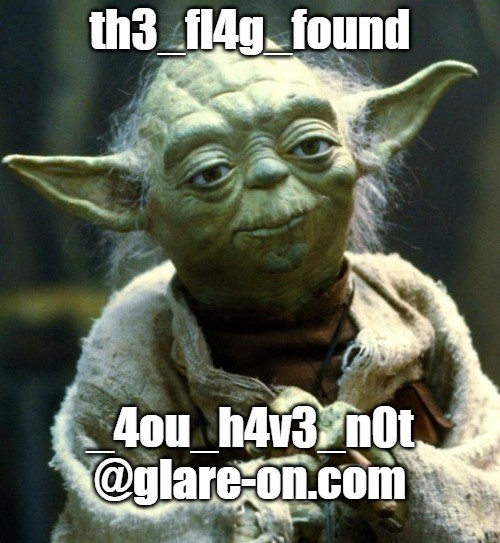

In [1]:
%emit y0da.exe | perc | rc4 patience_y0u_must_h4v3 | dump out.jpg
%show out.jpg

We return to reverse engineering the binary. The decrypted image resource is notably stored in a field in the main structure that is shared among the various threads. Indeed, the function at `180050e82` also accesses the field and does a few interesting things. First, it extracts two secrets from the decrypted image. It then generates a lot of random data using a standard LCG and the Mersenne Twister before it passes both secrets and some random data to the function at `18004936e`. Analyzing that function reveals that one of the two secrets actually contains CPU instructions, and the subroutine `18001d361` generates a ROP chain from it to serve as a decoding step for the other secret. It is safe to assume that the second secret is the encoded flag, and we will just call the other buffer `code.bin`:

In [1]:
%%emit out.jpg [
    | put a pos:h:ffe1aa3b
    | put b pos:h:ffe2a1c5
    | snip -l a+4:0x39 b+4:0x1C3
    | dump flag.enc code.bin ]

In [1]:
%ls

00.805 MB 040ed920519c37d85bafe5595ddf3a49dd61afb58ba2bc96df1a97570633797c y0da.exe
00.218 MB 62f8f28584f2069d011fe7d1d2429f473f91a815a8a9008f138cee7395124665 out.jpg
00.057 kB 5ade4851bbb8bfabfc57e4007a5f80a9b9b62593b9dba3220bb0b5b5c84d05a7 flag.enc
00.451 kB ab9fd6ff263ffb0403a07b6d143a63789b93fdc1d0012df5968cb24ec2fc53f6 code.bin


Next, we use the [vstack][] unit to extract the ROP-chain and dump it to a file `decoder.bin`. The complete pipeline looks as follows:

[vstack]: https://binref.github.io/#refinery.vstack

In [1]:
%%emit y0da.exe [
    | put R9 0
    | vstack -rXC 0x18001d361
    | chop 8 [
        | put k le:c::
        | emit read[k:64]:code.bin
        | opc x64 --until ret []
        | snip :-1 ]
    | dump decoder.bin ]]

In the malware, the offset of the in-memory buffer corresponding to `code.bin` is passed via the `R9` register to the decoder function. By initializing the chunk variable `R9` to zero using [put][], the [vstack][] unit will record only the offsets of the ROP-chain being written to the stack as a sequence of 64-bit values. We then [chop][] this sequence into chunks of 8 bytes, each containing the offset to the next chunk of instructions inside `code.bin`. We [put][] the little endian integer interpretation of those bytes into the variable `k` by using the expression `le:c::8`: This is a sequence of [multibin][] handlers. From right to left:

- `c::` is the copy handler `c`, followed by the handler separator `:`, followed by the slice expression `:`. This means to copy all bytes from the chunk body.
- `le:` is the little-endian handler, which converts the bytes that were copied to an integer using little endian encoding.

Next, we [emit][] 64 bytes from `code.bin`, starting at offset `k` by using the `read:` handler: That should be enough, since each part of the ropchain is fairly short. The [opc][] unit can disassemble this chunk until and including the first `ret` instruction. We use the _squeezing_ operator `[]` here to make [opc][] output the concatenation of all chunks it generated; by default it would output one chunk of bytes for each disassembled instruction into the current frame. After this step in the pipeline, we are looking at the chunks of code that form the ropchain, but they all still contain the `0xC3` byte at the end representing the `ret` instruction, so we use [snip][] to remove it.

At this point we have a linear representation of the code that is executed by the ropchain. We [dump][] it to disk and use [asm][] to print a short preview of the disassembly:

[vstack]: https://binref.github.io/#refinery.vstack
[chop]: https://binref.github.io/#refinery.chop
[opc]: https://binref.github.io/#refinery.opc
[asm]: https://binref.github.io/#refinery.asm
[dump]: https://binref.github.io/#refinery.dump
[snip]: https://binref.github.io/#refinery.snip
[emit]: https://binref.github.io/#refinery.emit
[put]: https://binref.github.io/#refinery.put
[rex]: https://binref.github.io/#refinery.rex
[multibin]: https://binref.github.io/lib/argformats.html

In [1]:
%emit decoder.bin | asm x64 [| pick :10 ]]

00000:  mov    eax, dword ptr [rbp + 0x24]  ; 8B 45 24           .E$   
00003:  mov    rcx, qword ptr [rbp + 0x40]  ; 48 8B 4D 40        H.M@  
00007:  movzx  eax, byte ptr [rcx + rax]    ; 0F B6 04 01        ....  
0000B:  mov    byte ptr [rbp + 0x20], al    ; 88 45 20           .E.   
0000E:  movzx  eax, byte ptr [rbp + 0x20]   ; 0F B6 45 20        ..E.  
00012:  sar    eax, 3                       ; C1 F8 03           ...   
00015:  movzx  ecx, byte ptr [rbp + 0x20]   ; 0F B6 4D 20        ..M.  
00019:  shl    ecx, 5                       ; C1 E1 05           ...   
0001C:  or     eax, ecx                     ; 0B C1              ..    
0001E:  mov    byte ptr [rbp + 0x20], al    ; 88 45 20           .E.   


In [1]:
%ls

00.805 MB 040ed920519c37d85bafe5595ddf3a49dd61afb58ba2bc96df1a97570633797c y0da.exe
00.218 MB 62f8f28584f2069d011fe7d1d2429f473f91a815a8a9008f138cee7395124665 out.jpg
00.057 kB 5ade4851bbb8bfabfc57e4007a5f80a9b9b62593b9dba3220bb0b5b5c84d05a7 flag.enc
00.451 kB ab9fd6ff263ffb0403a07b6d143a63789b93fdc1d0012df5968cb24ec2fc53f6 code.bin
01.818 kB 1b9adb01305b78b1b8f2eeac1af799dfaef61997f4ae01710faf5de5c1681072 decoder.bin


What is left to do is to open `decoder.bin` and analze it to figure out what the ropchain actually does. The disassembly above already gives a good impression: It performs a (fairly long) sequence of arithmetic and bitwise operations on the input (i.e. the encoded flag). At the very end, it also XOR's the result with the random data that was generated by the Mersenne Twister. 

Me and many other people I have talked to since were first trying to figure out how to generate the "correct" seed for the PRNG to decrypt the flag, and frankly I think the challenge would have been more satisfying, albeit probably harder, if that had been the way to do it: It is what seems to be the natural approach. Instead, the solution is to completely zero out the random bytes. Some very seasoned CTF players simply did that and scored the flag, but I did not have that intuition and instead re-implemented the entire ROP chain to experiment with. Eventually, after doing so for _quite_ some time, I noticed that right before XOR'ing with the random data, the ropchain produces printable characters. And well, that's the flag then. Here's my re-implementation of the decoder:

In [1]:
#!binary-refinery
from functools import partial, reduce

from refinery import Unit
from refinery.lib.crypto import rotr8 as rotr

class y0dac0de(Unit):
    @staticmethod
    def _round(b, k):
        def R(c): return partial(rotr, c=c)
        def X(c): return lambda a: a ^ c
        def A(c): return lambda a: a + c & 0xFF
        def S(c): return lambda a: a - c & 0xFF
        def I(a): return +a ^ 0xFF
        def N(a): return -a & 0xFF
        return reduce(lambda p, t: t(p), [
            R(3), A(0xAC), X(k), S(4), X(k), I, S(k), R(3), A(k), R(2), I, R(6), A(k), I, X(0x0D),
            N, A(0x7B), X(0xBF), A(0x3D), X(k), A(0x60), R(5), A(k), I, S(0x18), X(k), S(k), X(k),
            A(0xD), X(k), R(2), X(k), N, A(0x3B), I, R(7), A(1), R(7), S(k), X(0x8F), A(0x70), I,
            S(0x36), R(2), I, S(0x18), N, A(0xAA), X(k), R(6), X(k), A(k), I, R(5), X(0x40),
            A(0x66), I, A(k), X(0x16), A(0x7F), I, X(k), A(0x4E), R(2), N, A(0x70), I, S(0x28), N,
            S(k), N, R(2), A(0x24), R(7), X(0x7C), R(2), N, A(0x96), X(0xA3), I, S(k), R(6),
            X(0xCB), I, S(0x1A), X(0xB6), I, N, A(0x4F), I, N, I, N, X(0xE1), A(0x8F), R(1),
            A(0x5A), N, A(k), X(0x78), N, X(0xEB), I, X(k), A(k), X(k), N, X(0x25), R(7), A(k),
            X(0xC9), S(k), X(k), A(k), R(3), N, X(k), A(0xB7), I, S(0x1E), X(k), N, A(k), R(5),
            X(0x20), S(k), X(0x22), A(0xA8), N, X(k), S(k), R(6), N, S(k), I, S(0x1C), I, X(k),
            S(k), I, A(k), X(k), I, X(0xC2), S(k), I, A(k), I, N, R(7)
        ], b & 0xFF)

    def process(self, data):
        round = self._round
        for k, b in enumerate(data):
            data[k] = round(b, k)
        return data

And then it's real easy to get the flag:

In [1]:
%emit flag.enc | ./y0dac0de.py

P0w3rfu1_y0u_h4v3_b3c0m3_my_y0ung_flareaw4n@flare-on.com 
